## **Data Cleaning**

### 1/ Link g-collab with your drive & Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 3.2 MB/s 
     |████████████████████████████████| 2.8 MB 10.6 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
import numpy                    as np
import pandas                   as pd
import math
import openpyxl
import matplotlib.pyplot        as plt
import matplotlib.dates
import datetime
import seaborn                  as sns
import csv
from pypfopt                    import risk_models
from dateutil.relativedelta     import relativedelta
from pypfopt.expected_returns   import mean_historical_return
from pypfopt.risk_models        import sample_cov
from pypfopt.risk_models        import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt                    import plotting
from tabulate                   import tabulate

### 2/ If you want to clean your data, run this part
You need to do this a least once to get some new saved excel files with cleaned data at /content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)

In [ ]:
### Finding a list of ISIN which corresponds to the companies we want to study

# Create datasets with the regions and scopes
data_region = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/region.xlsx')

data_scope1 = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/scope1.xlsx')
data_scope2 = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/scope2.xlsx')
data_scope3 = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/scope3.xlsx')

# Merge the databases each with the regions
df_merge  = pd.merge(data_scope1, data_region, on = 'ISIN')
df_merge2 = pd.merge(data_scope2, data_region, on = 'ISIN')
df_merge3 = pd.merge(data_scope3, data_region, on = 'ISIN')

# Keep only European firms
df_merge  = df_merge.drop(df_merge[df_merge.Country !='EUR'].index)
df_merge2 = df_merge2.drop(df_merge2[df_merge2.Country !='EUR'].index)
df_merge3 = df_merge3.drop(df_merge3[df_merge3.Country !='EUR'].index)

# To check later on if the scope 1,2,3 have the same firms
companies_names_scope1 = df_merge.ISIN.unique()
companies_names_scope2 = df_merge2.ISIN.unique()
companies_names_scope3 = df_merge3.ISIN.unique()

# Check if the companies we have in the scope 1, 2 and 3 are the same
if (companies_names_scope2.all() == companies_names_scope1.all()) and (companies_names_scope2.all() == companies_names_scope3.all()):
  print("The companies are the same")
else:
  print("NO GO")

# A df of 1 columns with all the ISIN (& Names --> need to take 0:2 for this) of the companies we are interested in
my_companies  = df_merge.iloc[: , 0:1]

The companies are the same


In [ ]:
### Testing the data cleaning (Jasmina used for report)
data_merged = pd.merge(data_scope1, data_scope2, how = 'inner', on = 'ISIN')
data_merged = pd.merge(data_merged, data_scope3, how = 'inner', on = 'ISIN')
data_merged = pd.merge(data_merged, data_region, on = 'ISIN')
df_merge4   = data_merged.drop(data_merged[data_merged.Country !='EUR'].index)

print(len(df_merge4))

if (companies_names_scope1.all() == df_merge4.ISIN.unique().all()):
  print("Succes!")

2739
Succes!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'NAME_x'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.


In [ ]:
### Import datasets
data_div    = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/dy.xlsx')
data_prices = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/prices.xlsx')
data_size   = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/size.xlsx')

data_scope1intensity   = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/scope1intensity.xlsx')
data_scope2intensity   = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/scope2intensity.xlsx')
data_scope3intensity   = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/Data_Excel/Trucost_CO2emissions/scope3intensity.xlsx')

In [ ]:
### Clean datasets and transpose them

# Keep only entreprises we are interested in
my_dividends = pd.merge(my_companies, data_div, on=["ISIN"])
my_prices    = pd.merge(my_companies, data_prices, on=["ISIN"])
my_size      = pd.merge(my_companies, data_size, on=["ISIN"])
my_scope1intensity = pd.merge(my_companies, data_scope1intensity, on=['ISIN'])
my_scope2intensity = pd.merge(my_companies, data_scope2intensity, on=['ISIN'])
my_scope3intensity = pd.merge(my_companies, data_scope3intensity, on=['ISIN'])

my_dividends_T         = my_dividends.drop(["ISIN","NAME"], axis=1).transpose()
my_dividends_T.columns = my_dividends.ISIN

my_prices_T            = my_prices.drop(["ISIN","NAME"], axis=1).transpose()
my_prices_T.columns    = my_prices.ISIN

my_size_T              = my_size.drop(["ISIN","NAME"], axis=1).transpose()
my_size_T.columns      = my_size.ISIN

my_scope1intensity_T         = my_scope1intensity.drop(["ISIN","NAME"], axis=1).transpose()
my_scope1intensity_T.columns = my_scope1intensity.ISIN

my_scope2intensity_T         = my_scope2intensity.drop(["ISIN","NAME"], axis=1).transpose()
my_scope2intensity_T.columns = my_scope2intensity.ISIN

my_scope3intensity_T         = my_scope3intensity.drop(["ISIN","NAME"], axis=1).transpose()
my_scope3intensity_T.columns = my_scope3intensity.ISIN


# Create the file with returns
my_returns_T = my_prices_T.pct_change()
my_returns_T.replace([np.inf, -np.inf], np.nan, inplace = True)

# Create a list of corresponding dates
new_index = pd.date_range('1999-12-31','2020-12-31', 
              freq='M').strftime("%Y-%m-%d").tolist()

my_prices_T.index    = new_index
my_size_T.index      = new_index
my_returns_T.index   = new_index

# Drop year 1999
my_dividends_T = my_dividends_T.loc["x2005":,:]
my_prices_T    = my_prices_T.loc["2005-01-31":,:]
my_returns_T   = my_returns_T.loc["2005-01-31":,:]
my_scope1intensity_T = my_scope1intensity_T.loc["x2005":,:]
my_scope2intensity_T = my_scope2intensity_T.loc["x2005":,:]
my_scope3intensity_T = my_scope3intensity_T.loc["x2005":,:]

In [ ]:
my_ISIN_NAME = my_prices.loc[:,['ISIN','NAME']]

In [ ]:
# Save files
file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_dividends_T.xlsx'
my_dividends_T.to_excel(file_name, index=True)

file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_prices_T.xlsx'
my_prices_T.to_excel(file_name, index=True)

file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_size_T.xlsx'
my_size_T.to_excel(file_name, index=True)

file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_returns_T.xlsx'
my_returns_T.to_excel(file_name, index=True)

file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scope1intensity_T.xlsx'
my_scope1intensity_T.to_excel(file_name, index=True)

file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scope2intensity_T.xlsx'
my_scope2intensity_T.to_excel(file_name, index=True)

file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scope3intensity_T.xlsx'
my_scope3intensity_T.to_excel(file_name, index=True)

file_name = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_ISIN_NAME.xlsx'
my_ISIN_NAME.to_excel(file_name, index=True)

In [ ]:
### We do the selection of the 50 random firms and save it in order to always have the same ones

# /!\ If we run this code it changes the sample of firms

"""random50columns = my_returns_T.sample(n=50,axis=1).reset_index().drop("index", axis=1).columns.tolist()
print(random50columns)

filename = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/random_names.csv'
with open(filename, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(random50columns)"""

'random50columns = my_returns_T.sample(n=50,axis=1).reset_index().drop("index", axis=1).columns.tolist()\nprint(random50columns)\n\nfilename = \'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/random_names.csv\'\nwith open(filename, \'w\', newline="") as file:\n    csvwriter = csv.writer(file)\n    csvwriter.writerow(random50columns)'

### 3/ If you have already cleaned you data once, only run this part to import

In [ ]:
### Import clean data (Don't delete)
my_dividends_T       = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_dividends_T.xlsx',index_col=0)
my_prices_T          = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_prices_T.xlsx'   ,index_col=0)
my_size_T_VW         = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_size_T.xlsx'     ,index_col=0)
my_size_T            = my_size_T_VW.drop("1999-12-31")
my_returns_T         = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_returns_T.xlsx'  ,index_col=0)
my_rf                = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/FactorsAndRiskFreeRates/eurf.xlsx', header=None, names = ["Date", "rf"])
my_EU_market_returns = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/HW 1/FactorsAndRiskFreeRates/eumarket.xlsx', header=None, names = ["Date", "returns"])
my_scope1intensity_T = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scope1intensity_T.xlsx' ,index_col=0)
my_scope2intensity_T = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scope2intensity_T.xlsx' ,index_col=0)
my_scope3intensity_T = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scope3intensity_T.xlsx' ,index_col=0)
my_ISIN_NAME         = pd.read_excel(r'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_ISIN_NAME.xlsx'         ,index_col=0)

In [ ]:
### Duplicate 12 times each line to have the intensity per months // For each scope seperately first, then total emission (scopes 1-3)
scope1intensity = my_scope1intensity_T
df1 = pd.DataFrame()
year = 2005

for i in range(len(scope1intensity)):          #We want to go over each line and multiply it 12 times, but then we also need to jump 
  y = str(year)
  target_row = scope1intensity.iloc[i,:]            #Take one row of the initial dataframe at a time
  multiply_row = pd.DataFrame([target_row]*12)      #Create a dataframe where the targeted row is multiplied 12 times
  multiply_row.index = pd.date_range(y+'-01-31', y+'-12-31', freq='M').strftime("%Y-%m-%d").tolist()  #Change the index to a monthly recognisable date
  df1 = df1.append(multiply_row)                      #Append the "mini dataframe" (multiply_row) to the empty dataframe df
  year +=1                                          #Move onto the next year

#print(df.iloc[100:150,1:25]) -- Just to see what it looks like and to see that we are repeating every line with the same values over the same year for the same securities.

In [ ]:
scope2intensity = my_scope2intensity_T
df2 = pd.DataFrame()
year = 2005

for i in range(len(scope2intensity)):          #We want to go over each line and multiply it 12 times, but then we also need to jump 
  y = str(year)
  target_row = scope2intensity.iloc[i,:]            #Take one row of the initial dataframe at a time
  multiply_row = pd.DataFrame([target_row]*12)      #Create a dataframe where the targeted row is multiplied 12 times
  multiply_row.index = pd.date_range(y+'-01-31', y+'-12-31', freq='M').strftime("%Y-%m-%d").tolist()  #Change the index to a monthly recognisable date
  df2 = df2.append(multiply_row)                      #Append the "mini dataframe" (multiply_row) to the empty dataframe df
  year +=1    

In [ ]:
scope3intensity = my_scope3intensity_T
df3 = pd.DataFrame()
year = 2005

for i in range(len(scope3intensity)):          #We want to go over each line and multiply it 12 times, but then we also need to jump 
  y = str(year)
  target_row = scope3intensity.iloc[i,:]            #Take one row of the initial dataframe at a time
  multiply_row = pd.DataFrame([target_row]*12)      #Create a dataframe where the targeted row is multiplied 12 times
  multiply_row.index = pd.date_range(y+'-01-31', y+'-12-31', freq='M').strftime("%Y-%m-%d").tolist()  #Change the index to a monthly recognisable date
  df3 = df3.append(multiply_row)                      #Append the "mini dataframe" (multiply_row) to the empty dataframe df
  year +=1       

In [ ]:
### Duplicate 12 times each line to have the intensity per months
# creation of two new var:
#   - my_scopesintensity_T : All 3 scopes together
#   - my_scopesintensity_monthly : All 3 scopes together with values for each months

# Add the three scopes together
my_scopesintensity_T = my_scope1intensity_T + my_scope2intensity_T + my_scope3intensity_T

scopesintensity = my_scopesintensity_T
my_scopesintensity_monthly = pd.DataFrame()
year = 2005

for i in range(len(scopesintensity)):          # We want to go over each line and multiply it 12 times, 
                                               # but then we also need to jump 
  y = str(year)
  target_row = scopesintensity.iloc[i,:]            #Take one row of the initial dataframe at a time
  multiply_row = pd.DataFrame([target_row]*12)      #Create a dataframe where the targeted row is multiplied 12 times
  multiply_row.index = pd.date_range(y+'-01-31', y+'-12-31', freq='M').strftime("%Y-%m-%d").tolist()  #Change the index to a monthly recognisable date
  my_scopesintensity_monthly = my_scopesintensity_monthly.append(multiply_row)                      #Append the "mini dataframe" (multiply_row) to the empty dataframe df
  year +=1                                          #Move onto the next year

#print(my_scopesintensity_monthly.iloc[100:150,1:25]) -- Just to see what it looks like and to see that we are repeating every line with the same values over the same year for the same securities.

In [ ]:
### Here is the extraction of ISIN of the firms
file = open("/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/random_names.csv")
csvreader = csv.reader(file)
random50ISIN = next(csvreader)
file.close()

print('length of random50ISIN is', len(random50ISIN))
# Here is an example of how to create an random sample based on the ISIN only
"""randprout = my_returns_T.loc[:,random50ISIN]"""

length of random50ISIN is 50


'randprout = my_returns_T.loc[:,random50ISIN]'

## **Exercice 1**

In [ ]:
#Sum all the scopes for each firm and year
sum_scopes = my_scope1intensity_T.add(my_scope2intensity_T).add(my_scope3intensity_T)

(0.0, 1500.0)

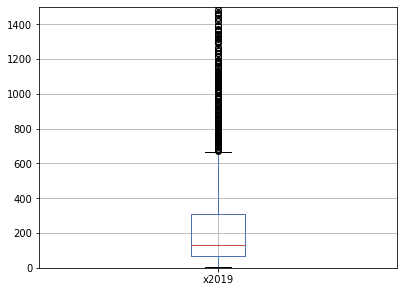

In [ ]:
#To compare with study of course
s = sum_scopes.loc["x2019"].to_frame()
s.boxplot()
plt.ylim(0, 1500)

In [ ]:
### Funciton to calculate for the sum of scopes the different parameters needed

# Input: Parameter ("mean", "median", "min", "max", "standard deviation")
# Outputs: scatterplot, boxplot, average of all values and the min and max

def fct_carbon_intensity_parameter(parameter):
  if parameter == "mean":
    ### Graph creation of for the mean
    my_scopeintensity_mean = sum_scopes.mean()

    plt.scatter(my_scopeintensity_mean.index, my_scopeintensity_mean)
    plt.title("Scopes sum mean intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scopes sum mean intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
      which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
      top=False,         # Ticks along the top edge are off
      labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_mean_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scopes sum mean intensities of all firms is: ",
          my_scopeintensity_mean.mean(), "The median of the Scopes sum mean intensities of all firms is: ",
          my_scopeintensity_mean.median(),". The range lies between", my_scopeintensity_mean.min(), 
          "and", my_scopeintensity_mean.max(), ".")
    #Same data but in a boxplot of the mean
    my_scopeintensity_meann = my_scopeintensity_mean.to_frame()
    my_scopeintensity_meann.boxplot()

  elif parameter == "median":
    ### Graph creation of the median
    my_scopeintensity_median = sum_scopes.median()

    plt.scatter(my_scopeintensity_median.index, my_scopeintensity_median)
    plt.title("Scopes sum median intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scopes sum median intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
      which='both',      # Both major and minor ticks are affected
      bottom=False,      # Ticks along the bottom edge are off
      top=False,         # Ticks along the top edge are off
      labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_median_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scopes sum median intensities of all firms is: ", 
          my_scopeintensity_median.mean(), "The median of the Scopes sum median intensities of all firms is: ", 
          my_scopeintensity_median.median(),". The range lies between", my_scopeintensity_median.min(), 
          "and", my_scopeintensity_median.max(), ".")
    #Same data but in a boxplot of the median
    my_scopeintensity_mediann = my_scopeintensity_median.to_frame()
    my_scopeintensity_mediann.boxplot()

  elif parameter == "min":
    ### Graph creation of the Min
    my_scopeintensity_min = sum_scopes.min()

    plt.scatter(my_scopeintensity_min.index, my_scopeintensity_min)
    plt.title("Scopes sum  min intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scopes sum min intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
       which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
      top=False,         # Ticks along the top edge are off
      labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_min_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scopes sum min intensities of all firms is: ", 
          my_scopeintensity_min.mean(),". The range lies between", my_scopeintensity_min.min(), 
          "and", my_scopeintensity_min.max(), ".")
    #Same data but in a boxplot for the min
    my_scopeintensity_minn = my_scopeintensity_min.to_frame()
    my_scopeintensity_minn.boxplot()

  elif parameter == "max":
    ### Graph creation of the Max
    my_scopeintensity_max = sum_scopes.max()

    plt.scatter(my_scopeintensity_max.index, my_scopeintensity_max)
    plt.title("Scopes sum max intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scopes sum max intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
       which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
       top=False,         # Ticks along the top edge are off
       labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_max_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scopes sum max intensities of all firms is: ", 
          my_scopeintensity_max.mean(),". The range lies between", my_scopeintensity_max.min(), 
          "and", my_scopeintensity_max.max(), ".")
    #Same data but in a boxplot for the max
    my_scopeintensity_maxx = my_scopeintensity_max.to_frame()
    my_scopeintensity_maxx.boxplot()
  
  elif parameter == "standard deviation":
       ### Graph creation of the Standard deviation
    my_scopeintensity_std = sum_scopes.std()

    plt.scatter(my_scopeintensity_std.index, my_scopeintensity_std)
    plt.title("Scopes sums' std deviation of intensities of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scopes sum std deviation of intensities")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
       which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
       top=False,         # Ticks along the top edge are off
       labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_std_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scopes sum std deviation of intensity of all firms is: ", 
          my_scopeintensity_std.mean(),". The range lies between", my_scopeintensity_std.min(), 
          "and", my_scopeintensity_std.max(), ".")
    #Same data but in a boxplot for the max
    my_scopeintensity_stdd = my_scopeintensity_std.to_frame()
    my_scopeintensity_stdd.boxplot()

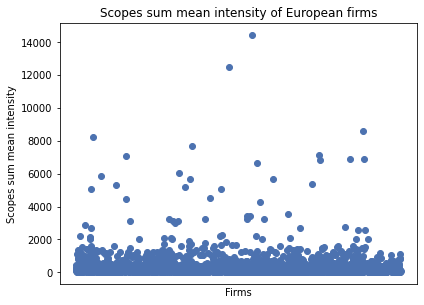

The mean of the Scopes sum mean intensities of all firms is:  337.81758217130647 The median of the Scopes sum mean intensities of all firms is:  137.79138101613896 . The range lies between 20.894975821178683 and 14461.870385286345 .


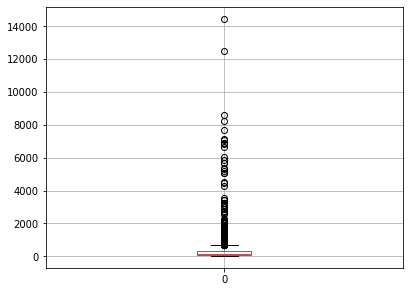

In [ ]:
fct_carbon_intensity_parameter("mean")

In [ ]:
#Calculate and show the firm and the mean emission of the two highest polluters
my_scopeintensity_mean = sum_scopes.mean()
my_scopeintensity_mean.nlargest(2)

GB00B129PL77    14461.870385
GB0006320161    12524.928124
dtype: float64

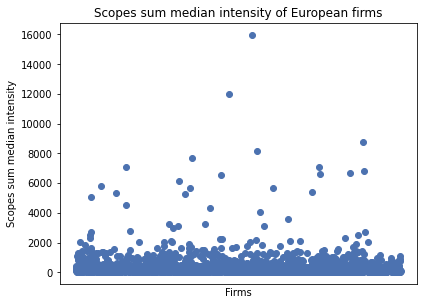

The mean of the Scopes sum median intensities of all firms is:  325.4208701574829 The median of the Scopes sum median intensities of all firms is:  133.250242657067 . The range lies between 22.2234176526651 and 15981.0228200594 .


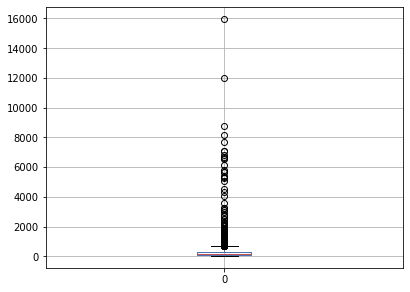

In [ ]:
fct_carbon_intensity_parameter("median")

The name of the asset with the highest mean annual emissions of the sum of scopes is GB00B129PL77 . It is mean carbon intensity of the sum of scopes is 15981.0228200594 .


GB00B129PL77    15981.022820
GB0006320161    11995.696842
dtype: float64

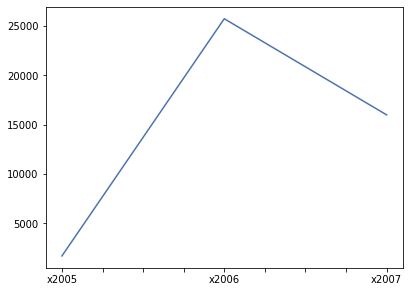

In [ ]:
#check for the higgest average outlier
my_scopeintensity_median = sum_scopes.median()

  # Find the asset with the highest mean carbon intensity per scope
scopemedian_max = my_scopeintensity_median.idxmax() # gets the ISIN of company which has the highest annualized return
  # Show the name of the asset with the highest carbon intensity, as well as that number
scopemedian_max_nb = my_scopeintensity_median.max()
print('The name of the asset with the highest mean annual emissions of the sum of scopes is', scopemedian_max,
        '. It is mean carbon intensity of the sum of scopes is', scopemedian_max_nb, '.')

#plot values of the firm with the higgest average emissions over all scopes
sum_scopes[scopemedian_max].plot()

my_scope1intensity_T[scopemedian_max]
my_scope2intensity_T[scopemedian_max]
my_scope3intensity_T[scopemedian_max]

my_scopeintensity_median.nlargest(2)

In [ ]:
my_scope1intensity_T[scopemedian_max]

x2005     1558.156187
x2006    25589.692365
x2007    15868.563915
x2008             NaN
x2009             NaN
x2010             NaN
x2011             NaN
x2012             NaN
x2013             NaN
x2014             NaN
x2015             NaN
x2016             NaN
x2017             NaN
x2018             NaN
x2019             NaN
x2020             NaN
Name: GB00B129PL77, dtype: float64

In [ ]:
my_scope2intensity_T[scopemedian_max]

x2005    6.847878
x2006    6.580216
x2007    7.113494
x2008         NaN
x2009         NaN
x2010         NaN
x2011         NaN
x2012         NaN
x2013         NaN
x2014         NaN
x2015         NaN
x2016         NaN
x2017         NaN
x2018         NaN
x2019         NaN
x2020         NaN
Name: GB00B129PL77, dtype: float64

In [ ]:
my_scope3intensity_T[scopemedian_max]

x2005    120.092211
x2006    123.219478
x2007    105.345410
x2008           NaN
x2009           NaN
x2010           NaN
x2011           NaN
x2012           NaN
x2013           NaN
x2014           NaN
x2015           NaN
x2016           NaN
x2017           NaN
x2018           NaN
x2019           NaN
x2020           NaN
Name: GB00B129PL77, dtype: float64

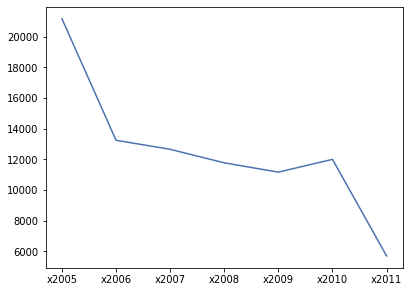

In [ ]:
sum_scopes["GB0006320161"].plot()

In [ ]:
my_scope1intensity_T["GB0006320161"]

x2005    20738.522878
x2006    12840.417345
x2007    12274.925159
x2008    11524.547205
x2009    10818.111758
x2010    11711.570882
x2011     5411.845218
x2012             NaN
x2013             NaN
x2014             NaN
x2015             NaN
x2016             NaN
x2017             NaN
x2018             NaN
x2019             NaN
x2020             NaN
Name: GB0006320161, dtype: float64

In [ ]:
my_scope2intensity_T["GB0006320161"]

x2005    0.502901
x2006    0.487135
x2007    0.444682
x2008    0.432081
x2009    0.428073
x2010    0.418494
x2011    0.399289
x2012         NaN
x2013         NaN
x2014         NaN
x2015         NaN
x2016         NaN
x2017         NaN
x2018         NaN
x2019         NaN
x2020         NaN
Name: GB0006320161, dtype: float64

In [ ]:
my_scope3intensity_T["GB0006320161"]

x2005    418.848282
x2006    399.043237
x2007    373.415423
x2008    243.871872
x2009    343.253524
x2010    283.707466
x2011    289.303965
x2012           NaN
x2013           NaN
x2014           NaN
x2015           NaN
x2016           NaN
x2017           NaN
x2018           NaN
x2019           NaN
x2020           NaN
Name: GB0006320161, dtype: float64

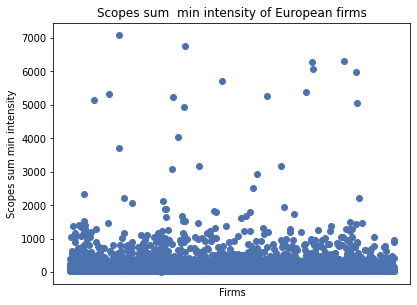

The mean of the Scopes sum min intensities of all firms is:  256.1872885823643 . The range lies between 5.116926977557433 and 7094.508153613157 .


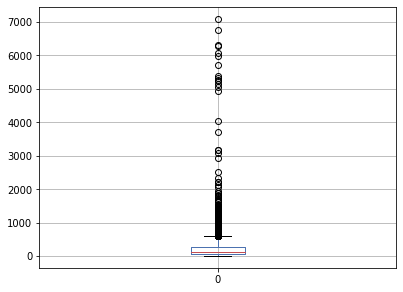

In [ ]:
fct_carbon_intensity_parameter("min")

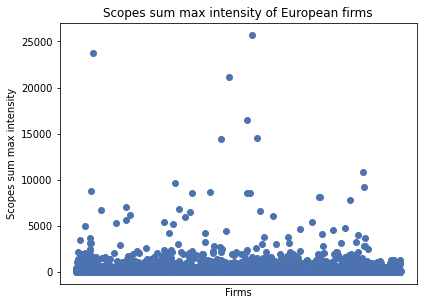

The mean of the Scopes sum max intensities of all firms is:  461.71793585360416 . The range lies between 24.420205904841172 and 25719.492059563345 .


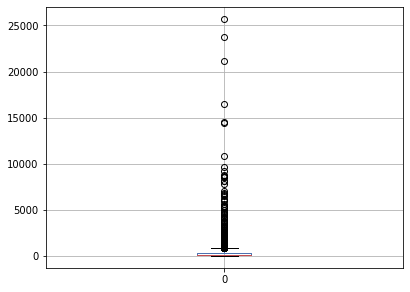

In [ ]:
fct_carbon_intensity_parameter("max")

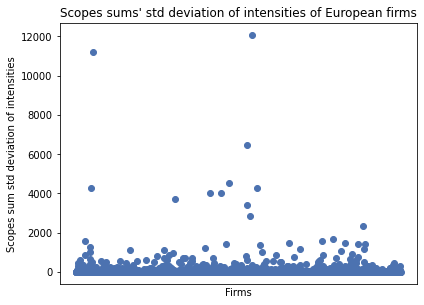

The mean of the Scopes sum std deviation of intensity of all firms is:  81.50008679334819 . The range lies between 0.16326939180046354 and 12088.999679769206 .


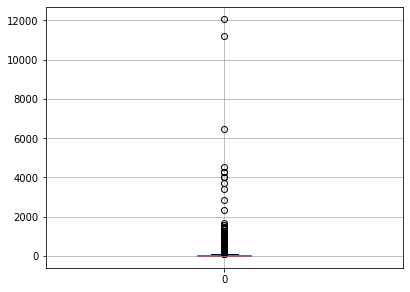

In [ ]:
fct_carbon_intensity_parameter("standard deviation")

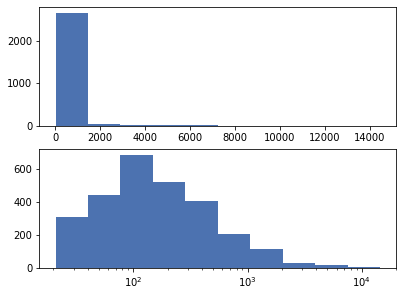

In [ ]:
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(my_scopeintensity_mean, bins=10)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(my_scopeintensity_mean, bins=logbins)
plt.xscale('log')
plt.show()

(array([2.551e+03, 1.330e+02, 2.100e+01, 1.100e+01, 3.000e+00, 8.000e+00,
        5.000e+00, 3.000e+00, 2.000e+00, 0.000e+00]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

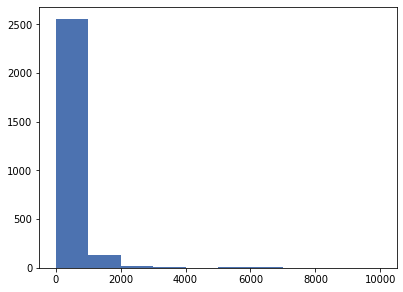

In [ ]:
plt.hist(my_scopeintensity_mean, bins = 10, range=(0,10000))

(array([1665.,  515.,  223.,   85.,   63.,   57.,   41.,   24.,    9.,
           2.]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <a list of 10 Patch objects>)

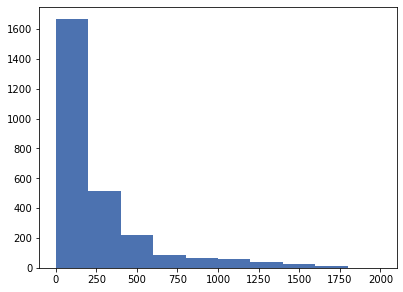

In [ ]:
plt.hist(my_scopeintensity_mean, bins = 10, range=(0,2000))

(array([  7., 441., 298., 187., 329., 190., 101., 112., 109.,  84.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 10 Patch objects>)

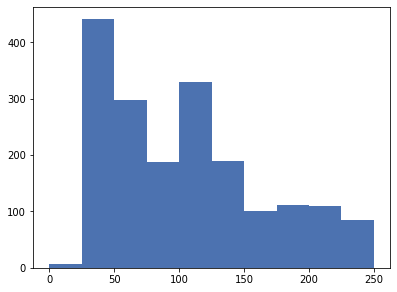

In [ ]:
plt.hist(my_scopeintensity_mean, bins = 10, range=(0,250))

(array([  0.,   0.,   0.,   0.,   7., 131.,  54., 118.,  66.,  72.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

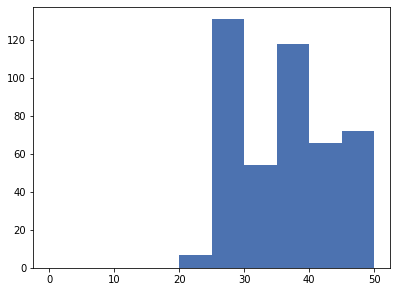

In [ ]:
plt.hist(my_scopeintensity_mean, bins = 10, range=(0,50))

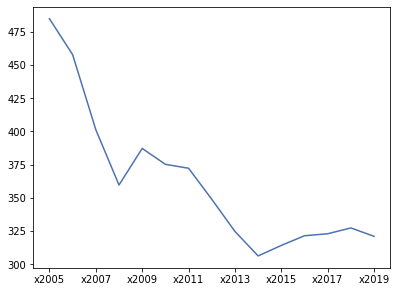

In [ ]:
#Calculate the mean of each year and plot it --> to see how the emissions of the three Scopes evolved with time
sum_scopes.mean(axis=1).plot()

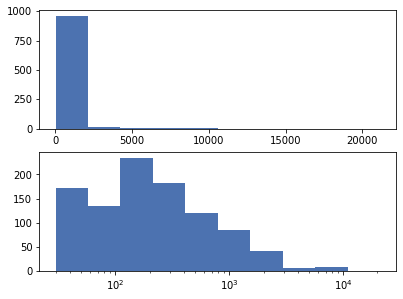

In [ ]:
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(sum_scopes.loc["x2005"], bins=10)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(sum_scopes.loc["x2005"], bins=logbins)
plt.xscale('log')
plt.show()

(array([521., 198.,  70.,  55.,  41.,  21.,  16.,   9.,  15.,  10.]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <a list of 10 Patch objects>)

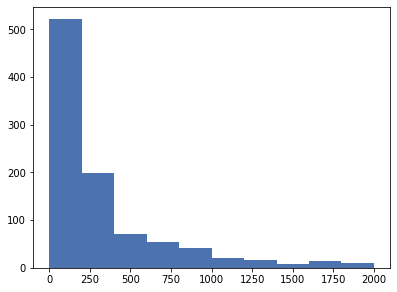

In [ ]:
plt.hist(sum_scopes.loc["x2005"], bins = 10, range=(0,2000))

(array([  0., 151.,  66.,  72.,  74.,  49.,  71.,  38.,  36.,  24.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 10 Patch objects>)

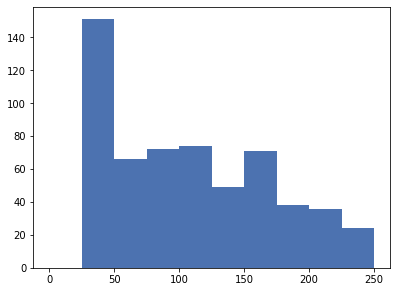

In [ ]:
plt.hist(sum_scopes.loc["x2005"], bins = 10, range=(0,250))

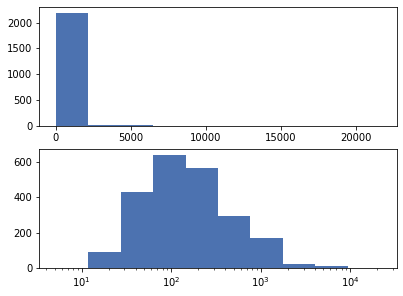

In [ ]:
# histogram on linear scale
plt.subplot(211)
hist, bins, _ = plt.hist(sum_scopes.loc["x2019"], bins=10)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(212)
plt.hist(sum_scopes.loc["x2019"], bins=logbins)
plt.xscale('log')
plt.show()

(array([1373.,  440.,  147.,   71.,   44.,   49.,   29.,   15.,   15.,
           4.]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <a list of 10 Patch objects>)

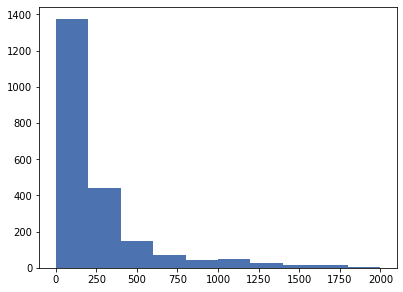

In [ ]:
plt.hist(sum_scopes.loc["x2019"], bins = 10, range=(0,2000))

(array([ 37., 365., 234., 166., 266., 122.,  91.,  92.,  95.,  67.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 10 Patch objects>)

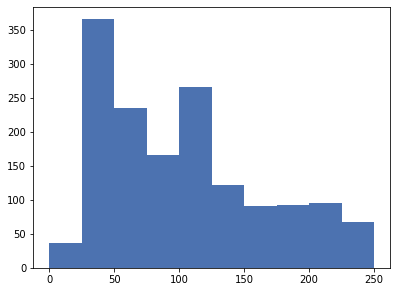

In [ ]:
plt.hist(sum_scopes.loc["x2019"], bins = 10, range=(0,250))

## **Exercice 2**

In [ ]:
### Keeping only 50 random firms
returns_Q2     = my_returns_T.loc[:,random50ISIN]
prices_Q2      = my_prices_T.loc [:,random50ISIN]
scope1int_Q2   = my_scope1intensity_T.loc[:,random50ISIN]
scope2int_Q2   = my_scope2intensity_T.loc[:,random50ISIN]
scope3int_Q2   = my_scope3intensity_T.loc[:,random50ISIN]
scopeTotint_Q2 = my_scopesintensity_T.loc[:,random50ISIN]

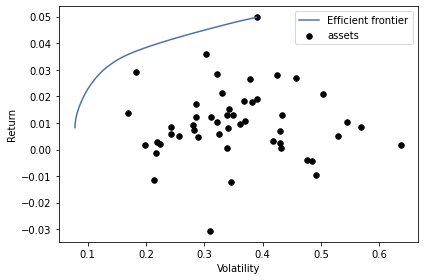

Sharpe ratio per targeted return for the 50 randomly selected firms 
╒═══════════════════╤══════════════╤════════════════╤════════════════════╕
│   Targeted Return │   Volatility │   Sharpe Ratio │   Carbon Intensity │
╞═══════════════════╪══════════════╪════════════════╪════════════════════╡
│             0.02  │    0.0931093 │    3.72621e-17 │            182.615 │
├───────────────────┼──────────────┼────────────────┼────────────────────┤
│             0.024 │    0.10386   │    0.0385135   │            190.802 │
├───────────────────┼──────────────┼────────────────┼────────────────────┤
│             0.028 │    0.118264  │    0.0676455   │            189.218 │
├───────────────────┼──────────────┼────────────────┼────────────────────┤
│             0.032 │    0.139169  │    0.0862259   │            217.045 │
├───────────────────┼──────────────┼────────────────┼────────────────────┤
│             0.036 │    0.171842  │    0.0931088   │            265.431 │
├───────────────────┼──────────

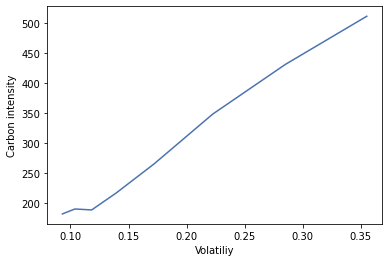

In [ ]:
### Optimal portfolios with various target portfolio returns

# Definitions
TARGETED_RETURN_START = 0.02
NB_OF_PORTFOLIOS      = 8

RETURN     = 0
VOLATILITY = 1
SHARPE     = 2
CI         = 3
NB_COL     = 4

targeted_return = TARGETED_RETURN_START

# Average returns & intensities will be used to create the portfolio
avr_returns = returns_Q2.mean(axis=0)
avr_scope_int = scopeTotint_Q2.mean(axis=0)

# To save the results
tr_pf = np.zeros((NB_OF_PORTFOLIOS,NB_COL)) # Create array with zeros to change later on

# Create a plot of the portfolio
S  = CovarianceShrinkage(prices_Q2, frequency = 12).ledoit_wolf()
ef = EfficientFrontier(avr_returns.values, S)
plotting.plot_efficient_frontier(ef)
plt.show()

# Calculate the steps used to create NB_OF_PORTFOLIOS. 
#     Aiming for a return of 16% was not feasible so instead we create the 
#     same number of portfolio but in a range which corresponds to our data 

# Calculates the step to still have 8 portfolios but between 0.2 and 
# max existing, round 3 after . (choice)
return_step = round((ef._max_return_value - TARGETED_RETURN_START)/NB_OF_PORTFOLIOS,3)


for r in range(NB_OF_PORTFOLIOS):
  weights            = ef.efficient_return(target_return = targeted_return)
  cleaned_weights    = ef.clean_weights()
  cleaned_weights_df = pd.DataFrame.from_dict(cleaned_weights, orient='index').transpose()

  tr_pf[r,RETURN]     = targeted_return
  tr_pf[r,VOLATILITY] = ef.portfolio_performance()[VOLATILITY]
  tr_pf[r,SHARPE]     = ef.portfolio_performance()[SHARPE]
  tr_pf[r,CI]         = avr_scope_int.mul(cleaned_weights_df).sum(axis=1)

  targeted_return = targeted_return + return_step


## Creation of the table
# Define header names
col_names = ["Targeted Return","Volatility", "Sharpe Ratio", "Carbon Intensity"]
  
# Display table
print("Sharpe ratio per targeted return for the 50 randomly selected firms",'\033[1m')
print(tabulate(tr_pf, headers=col_names, tablefmt ="fancy_grid"))

# Plot the CI(volatility)
x = tr_pf[:,1]
y = tr_pf[:,3]
plt.plot(x,y) 
plt.xlabel("Volatiliy") 
plt.ylabel("Carbon intensity") 
plt.show()

In [ ]:
top10_sorted = avr_scope_int.nlargest(10).sort_index()

tab_CI = my_ISIN_NAME[my_ISIN_NAME["ISIN"].isin(top10_sorted.index)]
tab_CI['CI'] = top10_sorted.values

tab_CI = tab_CI.sort_values(by=['CI'], ascending=False).reset_index(drop=True)

## Creation of the table
# Define header names
col_names = ["ISIN", "NAME", "Carbon Intensity"]
  
# Display table
print("Sharpe ratio per targeted return for the 50 randomly selected firms",'\033[1m')
print(tabulate(tab_CI.values, headers=col_names, tablefmt ="fancy_grid"))

Sharpe ratio per targeted return for the 50 randomly selected firms 
╒══════════════╤════════════════════════════════════╤════════════════════╕
│ ISIN         │ NAME                               │   Carbon Intensity │
╞══════════════╪════════════════════════════════════╪════════════════════╡
│ GB0002349065 │ REA HOLDINGS                       │           5090.35  │
├──────────────┼────────────────────────────────────┼────────────────────┤
│ AT0000741053 │ EVN                                │           1365.18  │
├──────────────┼────────────────────────────────────┼────────────────────┤
│ ES0132945017 │ TUBACEX                            │           1222.33  │
├──────────────┼────────────────────────────────────┼────────────────────┤
│ ES0177542018 │ INTL.CONS.AIRL.GP.                 │           1204.62  │
├──────────────┼────────────────────────────────────┼────────────────────┤
│ CH0021783391 │ PARGESA 'B' DEAD - DELIST.23/11/20 │           1137.06  │
├──────────────┼───────────────

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
my_scope1intensity_T

,ANN4327C1220,AT000000STR1,AT00000FACC2,AT00000VIE62,AT0000499157,AT0000606306,AT0000609607,AT0000612601,AT0000641352,AT0000642806,...,US8960951064,US8964383066,US89686D1054,US98387E2054,VGG379591065,VGG5884M1041,VGG6564A1057,XS0896158952,ZAE000156550,ZAE000255360
x2005,NaN,32.864748,NaN,29.624558,8.867880,1.347260,NaN,28.807669,NaN,15.711008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708479
x2006,NaN,31.297482,NaN,28.502541,8.653799,1.308070,NaN,27.549728,NaN,15.289691,...,NaN,NaN,NaN,NaN,119.749573,NaN,NaN,NaN,614.129299,0.679005
x2007,NaN,29.806772,NaN,27.198987,8.444887,1.270021,NaN,26.346715,NaN,14.879674,...,NaN,NaN,NaN,NaN,111.526785,NaN,NaN,NaN,535.631741,0.196566
x2008,NaN,27.209840,NaN,29.110032,8.221491,1.229191,NaN,25.191170,NaN,14.499850,...,NaN,NaN,NaN,NaN,269.922360,NaN,NaN,NaN,504.451122,0.483399
x2009,NaN,28.694659,NaN,29.765080,8.129470,1.222585,NaN,25.362644,NaN,14.323907,...,NaN,NaN,NaN,NaN,109.959687,NaN,NaN,NaN,586.706029,0.244920
x2010,NaN,49.717597,NaN,29.583920,NaN,1.207184,NaN,26.045580,NaN,NaN,...,NaN,NaN,NaN,NaN,86.287180,NaN,NaN,NaN,539.172951,0.348399
x2011,NaN,54.861629,NaN,27.338695,NaN,1.141461,NaN,24.685417,13.587097,NaN,...,NaN,NaN,NaN,NaN,76.054308,NaN,NaN,NaN,599.171632,0.572404
x2012,NaN,63.187371,NaN,26.995496,NaN,1.043770,NaN,NaN,13.697185,NaN,...,NaN,NaN,NaN,NaN,352.975553,NaN,NaN,NaN,580.247872,0.531803
x2013,NaN,59.090871,NaN,26.597419,NaN,1.061601,NaN,NaN,13.647417,NaN,...,NaN,NaN,NaN,NaN,277.909020,NaN,NaN,NaN,455.302367,0.808176
x2014,NaN,55.353893,NaN,29.006369,NaN,1.015798,NaN,NaN,13.920736,NaN,...,NaN,NaN,NaN,NaN,203.401039,NaN,NaN,NaN,518.209380,0.646001


In [ ]:
my_scope1intensity_T["GB0002349065"]

x2005      63.438723
x2006      58.558388
x2007      54.053497
x2008      52.731840
x2009      52.034556
x2010      39.365805
x2011      39.265296
x2012    3101.757067
x2013    3087.310027
x2014    2703.411623
x2015    4249.166379
x2016    7419.906726
x2017    3555.856306
x2018    3505.845603
x2019    3042.712197
x2020            NaN
Name: GB0002349065, dtype: float64

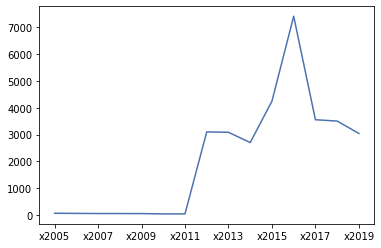

In [ ]:
my_scope1intensity_T["GB0002349065"].plot()


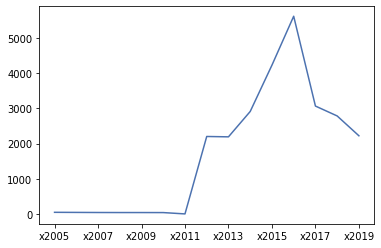

In [ ]:
my_scope2intensity_T["GB0002349065"].plot()

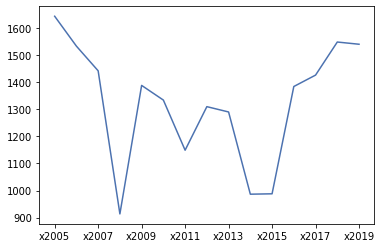

In [ ]:
my_scope3intensity_T["GB0002349065"].plot()


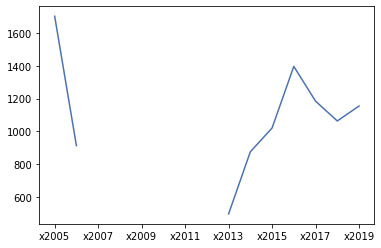

In [ ]:
my_scope1intensity_T["AT0000741053"].plot()

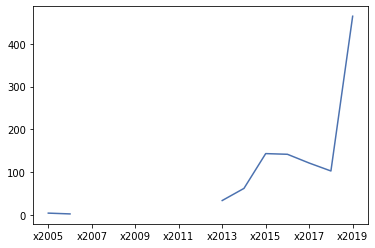

In [ ]:
my_scope2intensity_T["AT0000741053"].plot()

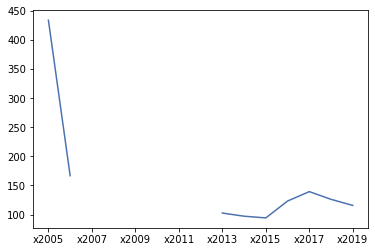

In [ ]:
my_scope3intensity_T["AT0000741053"].plot()


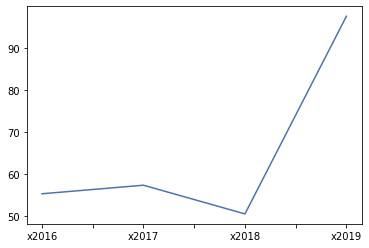

In [ ]:
my_scope1intensity_T["ES0132945017"].plot()

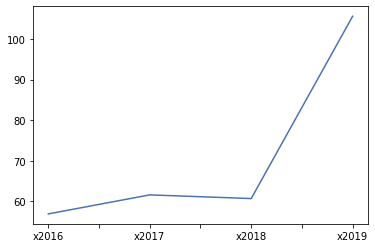

In [ ]:
my_scope2intensity_T["ES0132945017"].plot()

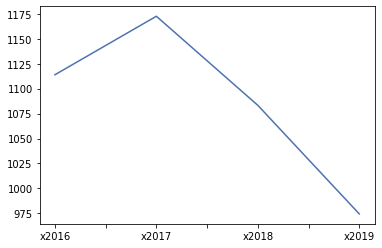

In [ ]:
my_scope3intensity_T["ES0132945017"].plot()

## **Exercice 3**

In [ ]:
###  Minimum variance portfolio with monthly rebalancing excluding highest emission firms

my_scopesintensity_monthly_Q3 = my_scopesintensity_monthly.loc[:,random50ISIN]
returns_Q3 = my_returns_T.loc[:,random50ISIN]
prices_Q3  = my_prices_T.loc [:,random50ISIN]


# Definitions 
STOP_KEEPING = round((len(my_scopesintensity_monthly_Q3.columns)/3)*2)
FIVE_YEARS    = 60 # 5*12months

# Start new list
MV_pf_returns_Q3 = []
MV_pf_weights_Q3 = []

WACI_per_month_Q3 = []

for r in range(FIVE_YEARS, len(my_scopesintensity_monthly_Q3)):
  # Sort by carbon intensity where we only keep the two bottom tercile (the highest firms are exclude)
  my_scopesintensity_monthly_Q3_tosort = my_scopesintensity_monthly_Q3.iloc[r,:]
  my_scopesintensity_monthly_Q3_sorted = my_scopesintensity_monthly_Q3_tosort.sort_values(axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)
  my_scopesintensity_monthly_Q3_keep = my_scopesintensity_monthly_Q3_sorted[:STOP_KEEPING] #remove top emitters

  # Take the prices & returns of the firms we are interested in
  prices_Q3_r = prices_Q3[my_scopesintensity_monthly_Q3_keep.index]
  returns_Q3_r = returns_Q3[my_scopesintensity_monthly_Q3_keep.index]

  # Only the returns of the month we are interested in and clean it
  monthly_returns = returns_Q3_r.iloc[r,:]
  monthly_returns = monthly_returns.dropna()

  # Only the prices of the month we are interested in
  prices_Q3_r = prices_Q3_r[monthly_returns.index]

  # Rolling window on 5 years
  prices_Q3_r = prices_Q3_r.iloc[r-FIVE_YEARS:r,:]

  # Portfolio Creation
  S = CovarianceShrinkage(prices_Q3_r, frequency=12).ledoit_wolf()
  ef = EfficientFrontier(monthly_returns.values.tolist(), S) 
  weights = ef.min_volatility()


  MV_pf_returns_Q3.append(ef.portfolio_performance()[0])

  my_scopesintensity_monthly_Q3_r = my_scopesintensity_monthly_Q3.loc[:,list(weights.keys())]

  WACI_per_month_Q3.append((list(weights.values())*my_scopesintensity_monthly_Q3_r.iloc[r,:]).sum(axis=0))

  #MV_pf_weights_Q3.append(weights)

WACI_Q3_new = (sum(WACI_per_month_Q3))/(len(WACI_per_month_Q3))

In [ ]:
print(my_scopesintensity_monthly_Q3.head(5))
print(prices_Q3.head(5))

            GB0002504529  CH0010754924  GB0002349065  GB00B081NX89  \
2005-01-31     366.77712           NaN   1752.026075           NaN   
2005-02-28     366.77712           NaN   1752.026075           NaN   
2005-03-31     366.77712           NaN   1752.026075           NaN   
2005-04-30     366.77712           NaN   1752.026075           NaN   
2005-05-31     366.77712           NaN   1752.026075           NaN   

            FR0000120578  AT0000741053  GB0031477770  IL0005830133  \
2005-01-31    162.000211   2140.451648           NaN           NaN   
2005-02-28    162.000211   2140.451648           NaN           NaN   
2005-03-31    162.000211   2140.451648           NaN           NaN   
2005-04-30    162.000211   2140.451648           NaN           NaN   
2005-05-31    162.000211   2140.451648           NaN           NaN   

            FR0010386334  SE0008321293  ...  ES0105229001  SE0001664707  \
2005-01-31           NaN    417.311106  ...           NaN           NaN   
2005-02-

In [ ]:
### Calculation of the portfolio properties

# Create a dataframe
pf_MV = pd.DataFrame(MV_pf_returns_Q3, columns = ['MV_pf_returns'])

# Annualized average return = (AAR)
AAR_MV_Q3 = pf_MV.mean()*12

# Annualized volatility
AV_MV_Q3 = pf_MV.std()*math.sqrt(12)
  
# Minimum return of portfolio (of the values of the loop above)
Min_ret_MV_Q3 = pf_MV.min()

# Maximum return
Max_ret_MV_Q3 = pf_MV.max()

# Sharpe ratio
SR_MV = (AAR_MV_Q3 - my_rf["rf"].mean()*12) / AV_MV_Q3

In [ ]:
### Summary Statistics to report the results

# Create data
data = [["Annualized average return", AAR_MV_Q3], 
        ["Annualized volatility", AV_MV_Q3], 
        ["Minimum return", Min_ret_MV_Q3], 
        ["Maximum return", Max_ret_MV_Q3],
        ["Sharpe ratio", SR_MV],
        ["Carbon Intensity", WACI_Q3_new]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Minimum variance portfolio with monthly rebalancing: Summary statistics",'\033[1m')
print(tabulate(data, headers = col_names, tablefmt = "fancy_grid"))

Minimum variance portfolio with monthly rebalancing: Summary statistics 
╒═══════════════════════════╤═══════════╕
│ Summary Statistic         │     Value │
╞═══════════════════════════╪═══════════╡
│ Annualized average return │  0.058365 │
├───────────────────────────┼───────────┤
│ Annualized volatility     │  0.149142 │
├───────────────────────────┼───────────┤
│ Minimum return            │ -0.131963 │
├───────────────────────────┼───────────┤
│ Maximum return            │  0.152573 │
├───────────────────────────┼───────────┤
│ Sharpe ratio              │  0.309185 │
├───────────────────────────┼───────────┤
│ Carbon Intensity          │ 30.4682   │
╘═══════════════════════════╧═══════════╛


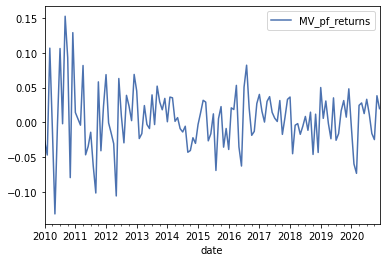

In [ ]:
### Plots

pf_MV['date'] = pd.date_range(start='31/1/2010', periods=len(pf_MV), freq='M')
pf_MV.plot(x = "date", y="MV_pf_returns")

## **Exercice 4**

In [ ]:
### Funciton to calculate the equally weighted portfolio

# Inputs: returns
# Outputs: average return of the pf

def fct_EW_creation(returns, scopes_int):
  sum = 0
  WACI = 0 
  # Create a df of only the values of interest, clean it and calculate the 
  # weight (equal for) each return
  if len(returns)==0:
    weight = "nan"
  else:
    weight = 1/len(returns)

  for n in range(len(returns)):
    sum += (returns[n]*weight)
    WACI += weight*scopes_int[n]
    
  return [sum,WACI]

In [ ]:
### Funciton to calculate the value weighted portfolio

# Inputs: returns, size
# Outputs: average return of the pf

def fct_VW_creation(returns,size,scopes_int):
  sum = 0
  WACI = 0
  # Create a df of only the values of interest, clean it
  total_size = size.sum()

  for n in range(len(returns)):
    if np.isnan(size[n]):
      weight = 0
    else:
      weight = size[n]/total_size

    sum += (returns[n]*weight)
    WACI += weight*scopes_int[n]
    
  return [sum,WACI]

In [ ]:
### Equally-weighted and value-weighted portfolios for each size quantiles and long-short for Q1&Q5

prices_Q4  = my_prices_T.copy()
returns_Q4 = my_returns_T.copy()
size_Q4    = my_size_T.copy()
size_Q4_VW = my_size_T_VW.copy()
scopes_Q4  = my_scopesintensity_monthly.copy()


QUANTILE_1 = 0 # Low emitters
QUANTILE_2 = 1
QUANTILE_3 = 2
QUANTILE_4 = 3
QUANTILE_5 = 4 # Big emitters
NB_QUANTILES = 5

# Create a list for the return of the EW
avr_ret_EW    = []
avr_ret_VW    = []
avr_ret_EW_sl = []
avr_ret_VW_sl = []
WACI_EW       = []
WACI_VW       = []


for m in range(len(returns_Q4)):
  avr_ret_EWq = []
  avr_ret_VWq = []
  WACI_EWq    = []
  WACI_VWq    = []
  avr_ret_EW_sl_q = 0   # For the portfolio short&long
  avr_ret_VW_sl_q = 0   # For the portfolio short&long
  
  # Order size
  scope_sorted = scopes_Q4.iloc[m,:].sort_values(axis=0, ascending=True, ignore_index=False).dropna()

  # split size in 5 quintiles -> Liste of names
  q_list = np.array_split(scope_sorted,5) # Split the pd.Series into 5 equal parts

  for q in range(NB_QUANTILES):
    # Only the returns of the month & firms we are interested in and clean it
    return_q = returns_Q4[q_list[q].index]
    return_q = return_q.iloc[m,:].dropna()

    # Only the size of the month & firms we are interested in for the VW pf
    size_q = size_Q4_VW[return_q.index]
    size_q = size_q.iloc[m,:]

    # Only the size of the month & firms we are interested in for the VW pf
    scope_int_q = scopes_Q4[return_q.index]
    scope_int_q = scope_int_q.iloc[m,:]

    # Only the prices of the month & firms we are interested in
    # prices_q = prices_Q4[return_q.index]

    # Create an EW pf 
    x = fct_EW_creation(return_q, scope_int_q)
    avrR_EW = x[0]
    avr_ret_EWq.append(avrR_EW)
    WACI_EWq.append(x[1])
    
    # Create a VW pf
    x = fct_VW_creation(return_q, size_q, scope_int_q)
    avrR_VW = x[0]
    avr_ret_VWq.append(avrR_VW)
    WACI_VWq.append(x[1])

    # For the EW & VW long & short pf
    if q == QUANTILE_1:
      avrR_EW_q1 = avrR_EW
      avrR_VW_q1 = avrR_VW
    elif q == QUANTILE_5:
      avr_ret_EW_sl_q = avrR_EW_q1 - avrR_EW
      avr_ret_VW_sl_q = avrR_VW_q1 - avrR_VW

  # Add to the final list
  avr_ret_EW.append(avr_ret_EWq)
  avr_ret_VW.append(avr_ret_VWq)
  avr_ret_EW_sl.append(avr_ret_EW_sl_q)
  avr_ret_VW_sl.append(avr_ret_VW_sl_q)
  WACI_EW.append(WACI_EWq)
  WACI_VW.append(WACI_VWq)


print(avr_ret_EW)
print(avr_ret_VW)
print(avr_ret_EW_sl)
print(avr_ret_VW_sl)
print(WACI_EW)
print(WACI_VW)

[[0.0012117533201615118, 0.00545050028024135, 0.021003062308141206, 0.01167307584934154, 0.01450115387792323], [0.0527782346934031, 0.05571295904085252, 0.045601530853964074, 0.06017085709592541, 0.08103466700498167], [-0.023552863046317582, -0.020464090940521252, -0.03159251704948426, -0.014208405640453958, -0.023238000270744616], [-0.027416230920201297, -0.02401547186224098, -0.011232574030879107, -0.047998083537571984, -0.025270129841072807], [0.0002465269975585752, -0.0014120152807726542, 0.0017841263414922765, 0.024080856356794203, 0.009138175604687566], [0.010150096157557697, 0.011987913280054234, 0.021649681783848105, 0.02433424842065185, 0.04212992508218223], [0.0392570383545588, 0.024626767291949996, 0.03511090650111587, 0.04952838639334611, 0.05078363229557583], [0.02856150426875882, 0.03560654502781421, 0.03933451892674454, 0.032633203113302194, 0.053997958021654316], [0.020317574151581533, -0.00015622555697284373, 0.01146528945388048, 0.030208789665871146, 0.043431851344763

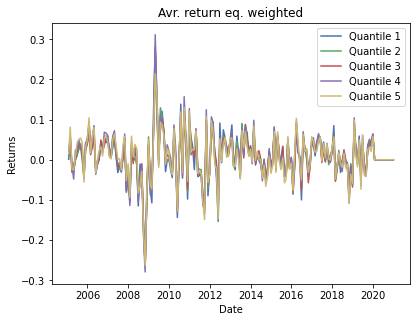

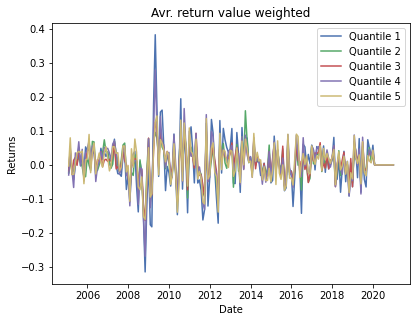

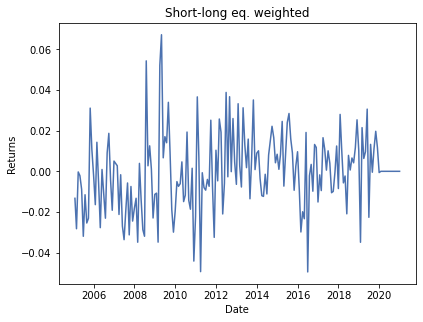

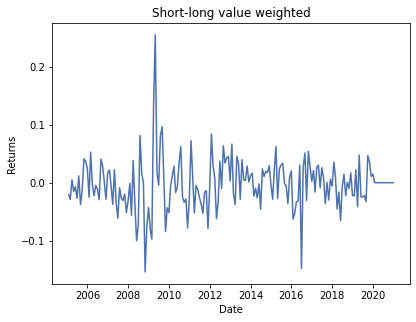

In [ ]:
### Graphs

# Eq. weighted
df = pd.DataFrame(avr_ret_EW)

returns_Q4.index = pd.to_datetime(returns_Q4.index)


plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_2], label='Quantile 2')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_3], label='Quantile 3')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_4], label='Quantile 4')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avr. return eq. weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Value weighted
df = pd.DataFrame(avr_ret_VW)

plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_2], label='Quantile 2')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_3], label='Quantile 3')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_4], label='Quantile 4')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avr. return value weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Short-long eq. w.
plt.plot(returns_Q4.index, avr_ret_EW_sl)
plt.title('Short-long eq. weighted')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Short-long value w.
plt.plot(returns_Q4.index, avr_ret_VW_sl)
plt.title('Short-long value weighted')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

In [ ]:
import statistics
print(statistics.mean(avr_ret_EW_sl),"&",statistics.mean(avr_ret_VW_sl))

-0.00030828982558711723 & -0.002598041001066617


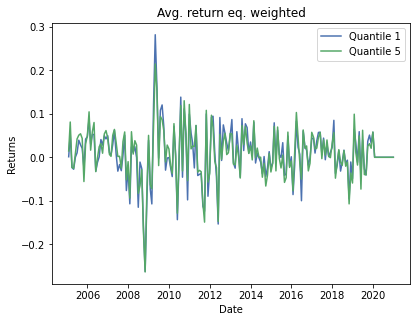

The average returns of Q1 over all years:  0.008151279346685364 . The average returns of Q5 over all years:  0.008459569172272478
0.008151279346685364 0.008059523917199904 0.008853670114453135 0.011093579894203218 0.008459569172272478


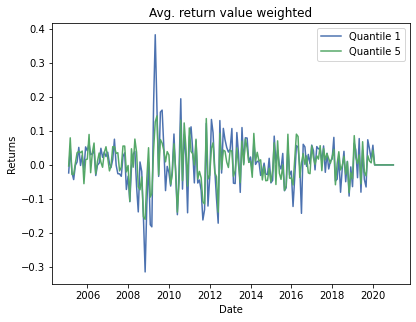

The average returns of Q1 over all years:  0.003537404331617087 . The average returns of Q5 over all years:  0.006135445332683708
0.003537404331617087 0.0048303987193467155 0.007376941739064572 0.009222161351601211 0.006135445332683708


In [ ]:
# report
df = pd.DataFrame(avr_ret_EW)


plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avg. return eq. weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

print("The average returns of Q1 over all years: ", df.iloc[:,QUANTILE_1].mean(), ". The average returns of Q5 over all years: ", df.iloc[:,QUANTILE_5].mean())
print(
    df.iloc[:,QUANTILE_1].mean(),
    df.iloc[:,QUANTILE_2].mean(),
    df.iloc[:,QUANTILE_3].mean(),
    df.iloc[:,QUANTILE_4].mean(),
    df.iloc[:,QUANTILE_5].mean()
)

df = pd.DataFrame(avr_ret_VW)


plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q4.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avg. return value weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

print("The average returns of Q1 over all years: ", df.iloc[:,QUANTILE_1].mean(), ". The average returns of Q5 over all years: ", df.iloc[:,QUANTILE_5].mean())
print(
    df.iloc[:,QUANTILE_1].mean(),
    df.iloc[:,QUANTILE_2].mean(),
    df.iloc[:,QUANTILE_3].mean(),
    df.iloc[:,QUANTILE_4].mean(),
    df.iloc[:,QUANTILE_5].mean()
)

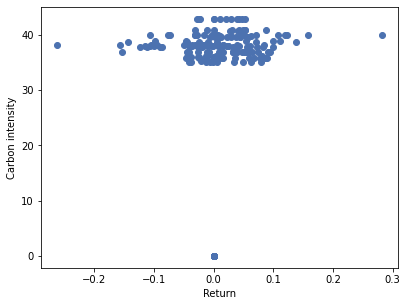

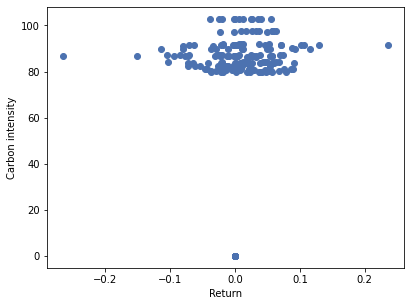

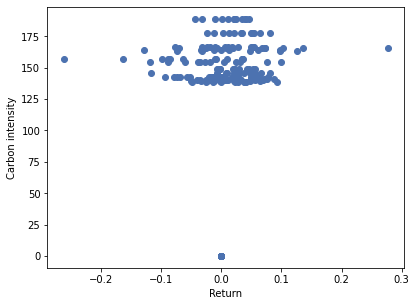

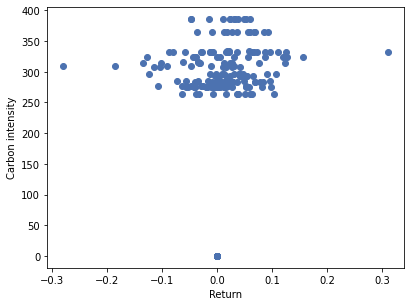

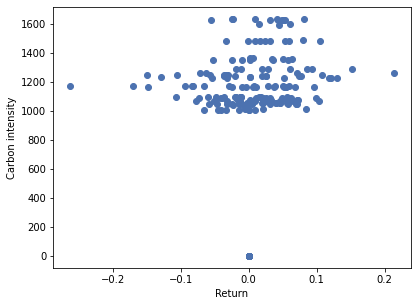

╒════════════╤═══════════════╕
│   Quantile │   Correlation │
╞════════════╪═══════════════╡
│          1 │     0.0473981 │
├────────────┼───────────────┤
│          2 │     0.0577222 │
├────────────┼───────────────┤
│          3 │     0.0620975 │
├────────────┼───────────────┤
│          4 │     0.0877102 │
├────────────┼───────────────┤
│          5 │     0.103485  │
╘════════════╧═══════════════╛


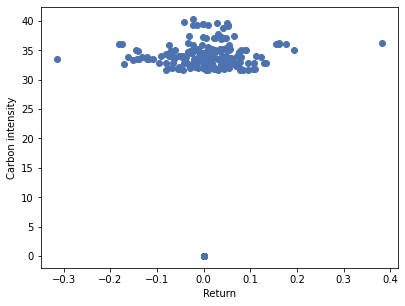

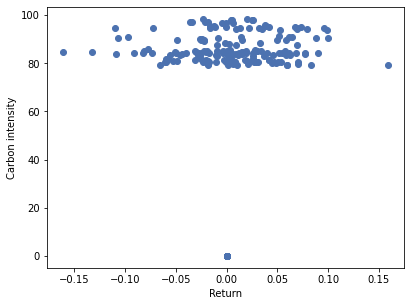

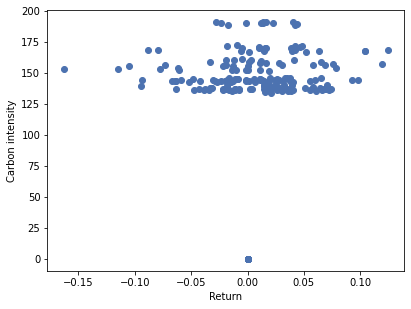

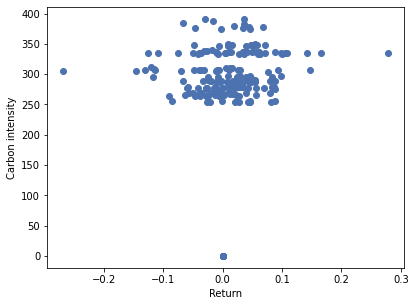

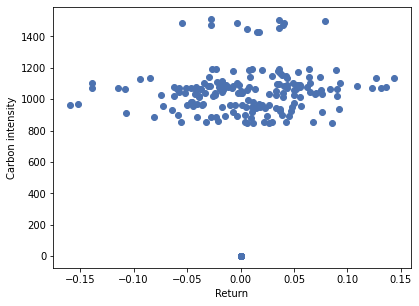

╒════════════╤═══════════════╕
│   Quantile │   Correlation │
╞════════════╪═══════════════╡
│          1 │     0.0296968 │
├────────────┼───────────────┤
│          2 │     0.0389941 │
├────────────┼───────────────┤
│          3 │     0.0580165 │
├────────────┼───────────────┤
│          4 │     0.0763124 │
├────────────┼───────────────┤
│          5 │     0.0739641 │
╘════════════╧═══════════════╛


In [ ]:
### Calulate the correlation between each portfolio return and its CI

## Eq. weighted
sum_stat = []
ret = pd.DataFrame(avr_ret_EW)
ci  = pd.DataFrame(WACI_EW)

for i in range(5):
  stat_corr=[[],[]]
  stat_corr[0] = i+1
  stat_corr[1] = ret.iloc[:,i].corr(ci.iloc[:,i])
  sum_stat.append(stat_corr)

  # Plot the relationship for between each protfolios return and its CI
  x = ret.iloc[:,i]
  y = ci.iloc[:,i]
  plt.scatter(x,y) 
  plt.xlabel("Return") 
  plt.ylabel("Carbon intensity") 
  plt.show()

sum_stat = pd.DataFrame(sum_stat)

# Creation of the table
col_names = ["Quantile", "Correlation"]
print(tabulate(sum_stat.values, headers=col_names, tablefmt ="fancy_grid"))




## Value weighted
sum_stat = []
ret = pd.DataFrame(avr_ret_VW)
ci  = pd.DataFrame(WACI_VW)

for i in range(5):
  stat_corr=[[],[]]
  stat_corr[0] = i+1
  stat_corr[1] = ret.iloc[:,i].corr(ci.iloc[:,i])
  sum_stat.append(stat_corr)

  # Plot the relationship for between each protfolios return and its CI
  x = ret.iloc[:,i]
  y = ci.iloc[:,i]
  plt.scatter(x,y) 
  plt.xlabel("Return") 
  plt.ylabel("Carbon intensity") 
  plt.show()

sum_stat = pd.DataFrame(sum_stat)

# Creation of the table
col_names = ["Quantile", "Correlation"]
print(tabulate(sum_stat.values, headers=col_names, tablefmt ="fancy_grid"))




## **Exercice 5**

In [ ]:
# Sorting the scope data, such that we only take years where there are no/little NaNs for the analysis
"""scope_intensity_Q5 = my_scopesintensity_monthly.iloc[132:180,:].dropna(axis=1) #from Jan 2016 to Dec 2019
print(scope_intensity_Q5) #from Jan 2016 to Dec 2019

#Before [48 rows x 2739 columns]
#After [48 rows x 1880 columns]
import random
new_list = scope_intensity_Q5.columns.tolist()
type(new_list)
new_50 = random.sample(new_list,50) # Do we need to code something for this to stay fix?
print(new_50)


filename = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/random_names_Q5.csv'
with open(filename, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(new_50)"""

'scope_intensity_Q5 = my_scopesintensity_monthly.iloc[132:180,:].dropna(axis=1) #from Jan 2016 to Dec 2019\nprint(scope_intensity_Q5) #from Jan 2016 to Dec 2019\n\n#Before [48 rows x 2739 columns]\n#After [48 rows x 1880 columns]\nimport random\nnew_list = scope_intensity_Q5.columns.tolist()\ntype(new_list)\nnew_50 = random.sample(new_list,50) # Do we need to code something for this to stay fix?\nprint(new_50)\n\n\nfilename = \'/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/random_names_Q5.csv\'\nwith open(filename, \'w\', newline="") as file:\n    csvwriter = csv.writer(file)\n    csvwriter.writerow(new_50)'

In [ ]:
file = open("/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/random_names_Q5.csv")
csvreader = csv.reader(file)
new_50 = next(csvreader)
file.close()

In [ ]:
# Importing the other Datasets 
returns_Q5 = my_returns_T.loc['2011-01-31':'2019-12-31',new_50] #take the columns of interest and the years of interest (for rolling window), Jan 2011 - Dec 2019
returns_Q5 = returns_Q5.reindex(sorted(returns_Q5.columns), axis=1) #reorder them in alphabetical order for the sake of the weights afterwards (scope data is already in this order)
# print(returns_Q5)
prices_Q5 = my_prices_T.loc['2011-01-31':'2019-12-31',new_50]
prices_Q5 = prices_Q5.reindex(sorted(prices_Q5.columns), axis=1)
scope_intensity_Q5 = my_scopesintensity_monthly.loc['2016-01-31':'2019-12-31',new_50]
scope_intensity_Q5 = scope_intensity_Q5.reindex(sorted(prices_Q5.columns), axis=1)
#print(scope_intensity_Q5)
#print(scope_intensity_Q5.head())

In [ ]:
# Re-running Question 4, HW1 with this new (fixed) set of random firms (Note for me: rand50_Q4 is the returns of those 50 firms)

### Optimal portfolio with minimum variance and monthly rebalancing
##      Using a rolling window of 5 years

# Definitions
FIVE_YEARS = 60 # 5yr * 12months = 60 months
RETURN     = 0

# Initialize the list
MV_pf_returns = []
MV_pf_weights = []
WACI_per_month = []

# For each month
for m in range(FIVE_YEARS, len(returns_Q5)):
  monthly_returns = returns_Q5.iloc[m,:]

  # Drop the firms which are not selling shares
  monthly_returns = monthly_returns.dropna()
  prices_Q5_r     = prices_Q5[monthly_returns.index]
  scope_r = scope_intensity_Q5[monthly_returns.index]

  # Rolling window on 5 years
  prices_Q5_r = prices_Q5_r.iloc[m-FIVE_YEARS:m,:]

  # Portfolio Creation
  S       = CovarianceShrinkage(prices_Q5_r, frequency=12).ledoit_wolf()
  ef      = EfficientFrontier(monthly_returns.values.tolist(), S) 
  weights = ef.min_volatility()

  element = (list(weights.values())*scope_r.iloc[m-FIVE_YEARS,:]).sum(axis=0)
  WACI_per_month.append(element)

  MV_pf_returns.append(ef.portfolio_performance()[RETURN])
  MV_pf_weights.append(weights)

In [ ]:
### Calculation of the portfolio properties

# Create a dataframe
pf_MV = pd.DataFrame(MV_pf_returns, columns = ['MV_pf_returns'])

# Annualized average return = (AAR)
AAR_MV_Q5 = pf_MV.mean()*12

# Annualized volatility
AV_MV_Q5 = pf_MV.std()*math.sqrt(12)
  
# Minimum return of portfolio (of the values of the loop above)
Min_ret_MV_Q5 = pf_MV.min()

# Maximum return
Max_ret_MV_Q5 = pf_MV.max()

# Sharpe ratio
SR_MV = (AAR_MV_Q5 - my_rf["rf"].mean()*12) / AV_MV_Q5

# Mean WACI
WACI_Q5 = (sum(WACI_per_month))/(len(WACI_per_month))

In [ ]:
### Summary Statistics to report the results

# Create data
data = [["Annualized average return", AAR_MV_Q5], 
        ["Annualized volatility", AV_MV_Q5], 
        ["Minimum return", Min_ret_MV_Q5], 
        ["Maximum return", Max_ret_MV_Q5],
        ["Sharpe ratio", SR_MV],
        ["Carbon Intensity", WACI_Q5]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Minimum variance portfolio with monthly rebalancing: Summary statistics",'\033[1m')
print(tabulate(data, headers = col_names, tablefmt = "fancy_grid"))

Minimum variance portfolio with monthly rebalancing: Summary statistics 
╒═══════════════════════════╤═════════════╕
│ Summary Statistic         │       Value │
╞═══════════════════════════╪═════════════╡
│ Annualized average return │   0.136863  │
├───────────────────────────┼─────────────┤
│ Annualized volatility     │   0.154025  │
├───────────────────────────┼─────────────┤
│ Minimum return            │  -0.0965251 │
├───────────────────────────┼─────────────┤
│ Maximum return            │   0.111624  │
├───────────────────────────┼─────────────┤
│ Sharpe ratio              │   0.809029  │
├───────────────────────────┼─────────────┤
│ Carbon Intensity          │ 187.539     │
╘═══════════════════════════╧═════════════╛


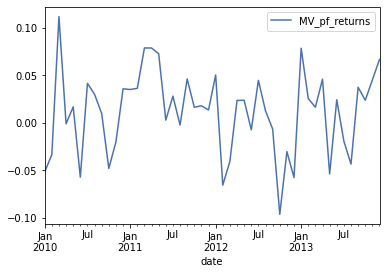

In [ ]:
### Plots

pf_MV['date'] = pd.date_range(start='31/1/2010', periods=len(pf_MV), freq='M')
pf_MV.plot(x = "date", y="MV_pf_returns")

In [ ]:
#print(WACI_per_month)

In [ ]:
#print(MV_pf_weights)

In [ ]:
# Re-running Question 4, HW1 with this new (fixed) set of random firms (Note for me: rand50_Q4 is the returns of those 50 firms)

### Optimal portfolio with minimum variance and monthly rebalancing
##      Using a rolling window of 5 years

# Definitions
FIVE_YEARS = 60 # 5yr * 12months = 60 months
RETURN     = 0

# Initialize the list
MV_pf_returns2 = []
MV_pf_weights2 = []
WACI_per_month2 = []

# For each month
for m in range(FIVE_YEARS, len(returns_Q5)):
  monthly_returns = returns_Q5.iloc[m,:]

  # Drop the firms which are not selling shares
  monthly_returns = monthly_returns.dropna()
  prices_Q5_r     = prices_Q5[monthly_returns.index]
  scope_r = scope_intensity_Q5[monthly_returns.index]

  # Rolling window on 5 years
  prices_Q5_r = prices_Q5_r.iloc[m-FIVE_YEARS:m,:]

  # Portfolio Creation
  S       = CovarianceShrinkage(prices_Q5_r, frequency=12).ledoit_wolf()
  ef2      = EfficientFrontier(monthly_returns.values.tolist(), S) 
  ef2.add_constraint(lambda x: sum(list(x)*scope_r.iloc[m-FIVE_YEARS,:]) <= 0.5*WACI_per_month[m-FIVE_YEARS])
  weights2 = ef2.min_volatility()

  element2 = (list(weights2.values())*scope_r.iloc[m-FIVE_YEARS,:]).sum(axis=0)
  WACI_per_month2.append(element2)

  MV_pf_returns2.append(ef2.portfolio_performance()[RETURN])
  MV_pf_weights2.append(weights2)

In [ ]:
### Calculation of the portfolio properties

# Create a dataframe
pf_MV = pd.DataFrame(MV_pf_returns2, columns = ['MV_pf_returns'])

# Annualized average return = (AAR)
AAR_MV_Q5_2 = pf_MV.mean()*12

# Annualized volatility
AV_MV_Q5_2 = pf_MV.std()*math.sqrt(12)
  
# Minimum return of portfolio (of the values of the loop above)
Min_ret_MV_Q5_2 = pf_MV.min()

# Maximum return
Max_ret_MV_Q5_2 = pf_MV.max()

# Sharpe ratio
SR_MV = (AAR_MV_Q5_2 - my_rf["rf"].mean()*12) / AV_MV_Q5_2

# Mean WACI
WACI_Q5_2 = (sum(WACI_per_month2))/(len(WACI_per_month2))

In [ ]:
### Summary Statistics to report the results

# Create data
data = [["Annualized average return", AAR_MV_Q5_2], 
        ["Annualized volatility", AV_MV_Q5_2], 
        ["Minimum return", Min_ret_MV_Q5_2], 
        ["Maximum return", Max_ret_MV_Q5_2],
        ["Sharpe ratio", SR_MV],
        ["Carbon Intensity", WACI_Q5_2]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Minimum variance portfolio with monthly rebalancing: Summary statistics",'\033[1m')
print(tabulate(data, headers = col_names, tablefmt = "fancy_grid"))

Minimum variance portfolio with monthly rebalancing: Summary statistics 
╒═══════════════════════════╤════════════╕
│ Summary Statistic         │      Value │
╞═══════════════════════════╪════════════╡
│ Annualized average return │  0.150076  │
├───────────────────────────┼────────────┤
│ Annualized volatility     │  0.155773  │
├───────────────────────────┼────────────┤
│ Minimum return            │ -0.0885206 │
├───────────────────────────┼────────────┤
│ Maximum return            │  0.119041  │
├───────────────────────────┼────────────┤
│ Sharpe ratio              │  0.884769  │
├───────────────────────────┼────────────┤
│ Carbon Intensity          │ 93.7694    │
╘═══════════════════════════╧════════════╛


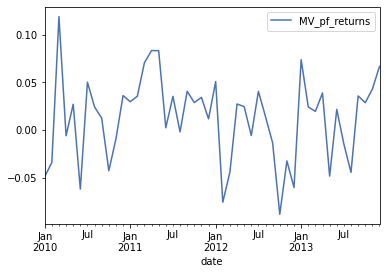

In [ ]:
### Plots

pf_MV['date'] = pd.date_range(start='31/1/2010', periods=len(pf_MV), freq='M')
pf_MV.plot(x = "date", y="MV_pf_returns")

In [ ]:
#print(WACI_per_month2)

In [ ]:
#len(WACI_per_month2) #Because we have 4 complete years --> 12*4

In [ ]:
#sum(list(weights.values())*scope_r.iloc[0,:])

In [ ]:
df_weights = pd.DataFrame(MV_pf_weights)
#print(df_weights)

In [ ]:
(df_weights2 == 0) & (df_weights != 0)

,BE0003764785,BE0974320526,CH0011115703,CH0030380734,CH0118530366,CH0367427686,CH0466642201,DE0005140008,DE0007100000,DE0007231326,...,NL0011821202,NL0013332471,NL00150001Q9,NO0003921009,NO0010199151,NO0010299068,NO0010716582,SE0002133975,SE0007691613,GB00BYV24996
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
6,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
7,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
8,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
9,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
((df_weights2 == 0) & (df_weights != 0)).sum()

BE0003764785     7
BE0974320526    32
CH0011115703     0
CH0030380734    16
CH0118530366     0
CH0367427686     0
CH0466642201     0
DE0005140008     0
DE0007100000     8
DE0007231326     0
DE0008019001     0
DE000A0JC8S7     0
DE000A288904     0
DE000A2NB601    15
DE000BASF111    38
DE000GSW1111     0
DK0010234467     5
ES0119256032     0
FR0000030827     0
FR0000131757     0
FR0011981968     0
FR0012435121     0
GB0002018363     0
GB0002668464     0
GB0004544929     0
GB0009067447     0
GB00B4WFW713     0
GB00B63H8491     0
GB00BG49KP99     0
GB00BVV2KN49     0
GB00BYZFZ918     0
GG00BMGYLN96     0
IE00BDC5DG00     0
IL0005930388     0
IL0010943905    36
IL0010952641     2
IT0004171440    48
IT0004827447     0
IT0005042467    48
NL0010391025     0
NL0011821202     0
NL0013332471     0
NL00150001Q9    26
NO0003921009    29
NO0010199151     5
NO0010299068     2
NO0010716582     0
SE0002133975    34
SE0007691613     0
GB00BYV24996     0
dtype: int64

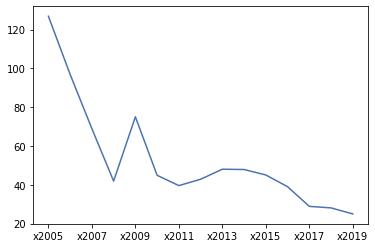

In [ ]:
my_scope1intensity_T["BE0974320526"].plot()

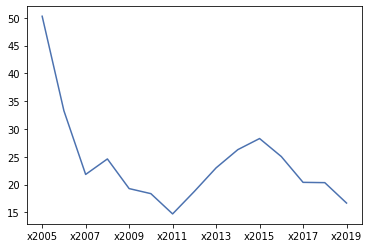

In [ ]:
my_scope2intensity_T["BE0974320526"].plot()

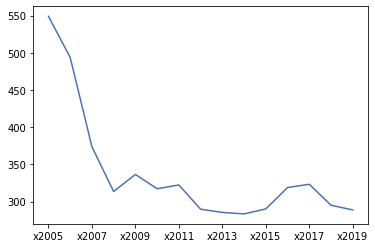

In [ ]:
my_scope3intensity_T["BE0974320526"].plot()

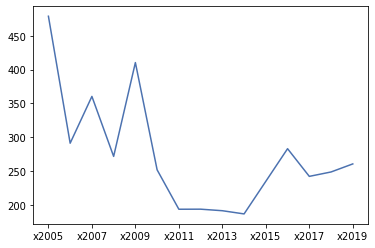

In [ ]:
my_scope1intensity_T["DE000BASF111"].plot()

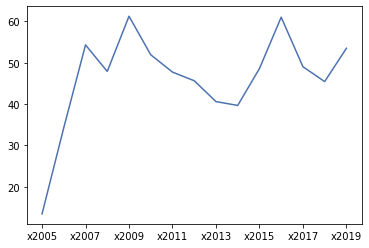

In [ ]:
my_scope2intensity_T["DE000BASF111"].plot()

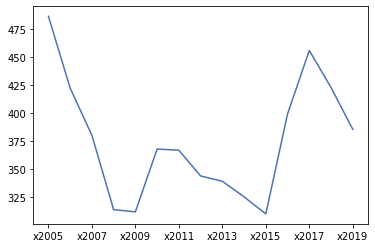

In [ ]:
my_scope3intensity_T["DE000BASF111"].plot()

In [ ]:
df_weights2 = pd.DataFrame(MV_pf_weights2)
#print(df_weights2)

In [ ]:
df_weights_difference = df_weights2-df_weights
#print(df_weights_difference)

In [ ]:
df_weights_avg_difference = df_weights_difference.mean(axis=0)
#print(df_weights_avg_difference)

<Figure size 432x288 with 0 Axes>

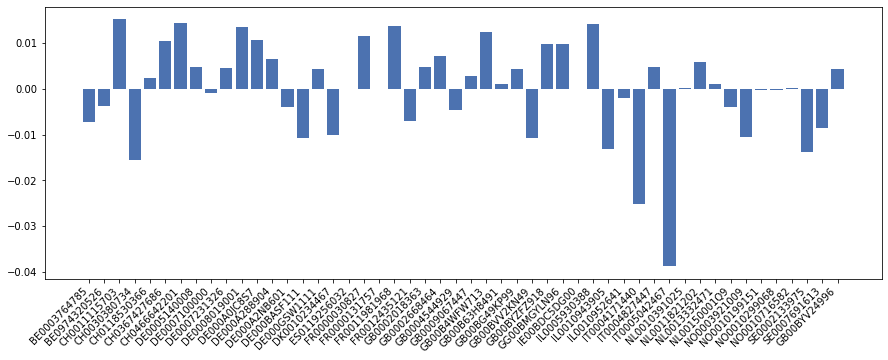

In [ ]:
fig = plt.figure()
plt.figure(figsize=[15,5])
plt.bar(df_weights_avg_difference.index,df_weights_avg_difference)
plt.xticks(rotation=45, ha = 'right')
plt.show()

In [ ]:
max = df_weights_avg_difference.max()
print(df_weights_avg_difference.idxmax())

CH0011115703


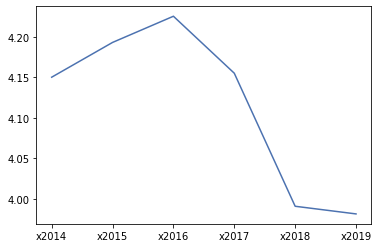

In [ ]:
my_scope1intensity_T["CH0011115703"].plot()

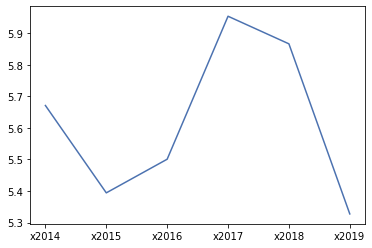

In [ ]:
my_scope2intensity_T["CH0011115703"].plot()

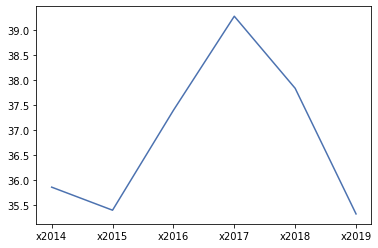

In [ ]:
my_scope3intensity_T["CH0011115703"].plot()

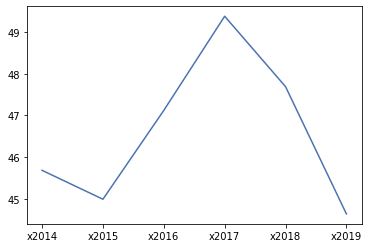

In [ ]:
my_scopesintensity_T["CH0011115703"].plot()

In [ ]:
min = df_weights_avg_difference.min()
print(df_weights_avg_difference.idxmin())

IT0005042467


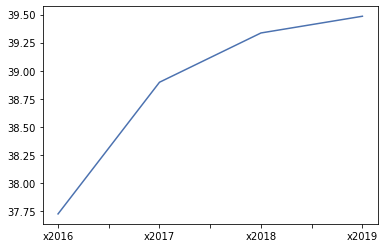

In [ ]:
my_scope1intensity_T["IT0005042467"].plot()

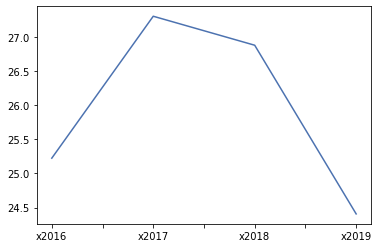

In [ ]:
my_scope2intensity_T["IT0005042467"].plot()

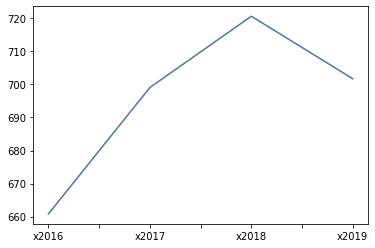

In [ ]:
my_scope3intensity_T["IT0005042467"].plot()

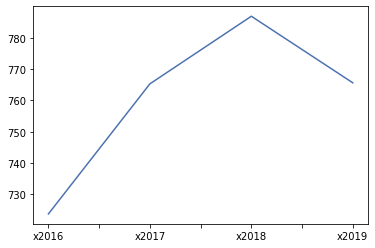

In [ ]:
my_scopesintensity_T["IT0005042467"].plot()

In [ ]:
my_ISIN_NAME[my_ISIN_NAME['ISIN']=='CH0011115703']

,ISIN,NAME
196,CH0011115703,CREALOGIX HOLDING


In [ ]:
my_ISIN_NAME[my_ISIN_NAME['ISIN']=='IT0005042467']

,ISIN,NAME
2139,IT0005042467,MASSIMO ZANETTI BEV.GP. DEAD - DELIST.15/02/21


## **Appendix**


In [ ]:
### Funciton to calculate for each scopes the different parameters needed

# Inputs:
  #scope intensity (my_scope1intensity_T, my_scope2intensity_T, my_scope3intensity_T)
  #scope ("1", "2", "3")
  #Parameter ("mean", "median", "min", "max", "standard deviation")
# Outputs: scatterplot, boxplot, average of all values and the min and max

def fct_carbon_intensity_parameter(my_scopeintensity_T, scope, parameter):
  if parameter == "mean":
    ### Graph creation of for the mean
    my_scopeintensity_mean = my_scopeintensity_T.mean()

    plt.scatter(my_scopeintensity_mean.index, my_scopeintensity_mean)
    plt.title("Scope " + scope + " mean intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scope " + scope + " mean intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
      which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
      top=False,         # Ticks along the top edge are off
      labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_mean_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scope " + scope + " mean intensities of all firms is: ",
          my_scopeintensity_T.mean().mean(),". The range lies between", my_scopeintensity_mean.min(), 
          "and", my_scopeintensity_mean.max(), ".")
    #Same data but in a boxplot of the mean
    my_scopeintensity_meann = my_scopeintensity_mean.to_frame()
    my_scopeintensity_meann.boxplot()

  elif parameter == "median":
    ### Graph creation of the median
    my_scopeintensity_median = my_scopeintensity_T.median()

    plt.scatter(my_scopeintensity_median.index, my_scopeintensity_median)
    plt.title("Scope " + scope + " median intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scope " + scope + " median intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
      which='both',      # Both major and minor ticks are affected
      bottom=False,      # Ticks along the bottom edge are off
      top=False,         # Ticks along the top edge are off
      labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_median_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scope " + scope + " median intensities of all firms is: ", 
          my_scopeintensity_median.mean(),". The range lies between", my_scopeintensity_median.min(), 
          "and", my_scopeintensity_median.max(), ".")
    #Same data but in a boxplot of the median
    my_scopeintensity_mediann = my_scopeintensity_median.to_frame()
    my_scopeintensity_mediann.boxplot()

  elif parameter == "min":
    ### Graph creation of the Min
    my_scopeintensity_min = my_scopeintensity_T.min()

    plt.scatter(my_scopeintensity_min.index, my_scopeintensity_min)
    plt.title("Scope " + scope + " min intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scope " + scope + " min intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
       which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
      top=False,         # Ticks along the top edge are off
      labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_min_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scope  " + scope + " min intensities of all firms is: ", 
          my_scopeintensity_min.mean(),". The range lies between", my_scopeintensity_min.min(), 
          "and", my_scopeintensity_min.max(), ".")
    #Same data but in a boxplot for the min
    my_scopeintensity_minn = my_scopeintensity_min.to_frame()
    my_scopeintensity_minn.boxplot()

  elif parameter == "max":
    ### Graph creation of the Max
    my_scopeintensity_max = my_scopeintensity_T.max()

    plt.scatter(my_scopeintensity_max.index, my_scopeintensity_max)
    plt.title("Scope " + scope + " max intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scope " + scope + " max intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
       which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
       top=False,         # Ticks along the top edge are off
       labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_max_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scope " + scope + " max intensities of all firms is: ", 
          my_scopeintensity_max.mean(),". The range lies between", my_scopeintensity_max.min(), 
          "and", my_scopeintensity_max.max(), ".")
    #Same data but in a boxplot for the max
    my_scopeintensity_maxx = my_scopeintensity_max.to_frame()
    my_scopeintensity_maxx.boxplot()
  
  elif parameter == "standard deviation":
       ### Graph creation of the Standard deviation
    my_scopeintensity_std = my_scopeintensity_T.std()

    plt.scatter(my_scopeintensity_std.index, my_scopeintensity_std)
    plt.title("Scope " + scope + " std intensity of European firms")
    plt.xlabel("Firms")
    plt.ylabel("Scope " + scope + " std intensity")
    plt.tick_params(
      axis='x',          # Changes apply to the x-axis
       which='both',      # Both major and minor ticks are affected
       bottom=False,      # Ticks along the bottom edge are off
       top=False,         # Ticks along the top edge are off
       labelbottom=False) # Labels along the bottom edge are off
    plt.show()
    #fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_scopeintensity_std_plot.png'
    #plt.savefig(fn)
    print("The mean of the Scope " + scope + " std intensity of all firms is: ", 
          my_scopeintensity_std.mean(),". The range lies between", my_scopeintensity_std.min(), 
          "and", my_scopeintensity_std.max(), ".")
    #Same data but in a boxplot for the max
    my_scopeintensity_stdd = my_scopeintensity_std.to_frame()
    my_scopeintensity_stdd.boxplot()

-------------------------------------------------------
# **HW 1!!!**
-------------------------------------------------------

## **Exercice 1**

In [ ]:
### Calculation of the returns
return_Q1  = my_returns_T.copy()
mean_Q1    = return_Q1.mean()*12
vol_Q1     = return_Q1.std()*(math.sqrt(12))
print("The correlation between the average annualized return and the volatility of the securities is: ", mean_Q1.corr(vol_Q1))
# We see that this is in the right direction (with respect to the theory), but we can perhaps find a better result if we temporarily discard the NaNs.
return_Q1b = return_Q1.dropna(axis=1) # this makes the number of companies drop from 2739 to 1371 (drop any column with a NaN value (post (=after) dec 1999 line dropped above))
mean_Q1b   = return_Q1b.mean()*12
vol_Q1b    = return_Q1b.std()*(math.sqrt(12))
print("The correlation is now: ", mean_Q1b.corr(vol_Q1b), "We can this see that this improves the observed correlation between securities, even though the basket of assets was reduced from 2739 to 1371 (less than half). This is not ideal, so we will not consider the reduced sample for upcoming exercises, but we will keep in mind the NaN and adapt our code to best reflect the reality behind the data.")

The correlation between the average annualized return and the volatility of the securities is:  0.5369536375982085
The correlation is now:  0.794554872344337 We can this see that this improves the observed correlation between securities, even though the basket of assets was reduced from 2739 to 1371 (less than half). This is not ideal, so we will not consider the reduced sample for upcoming exercises, but we will keep in mind the NaN and adapt our code to best reflect the reality behind the data.


In [ ]:
### Compute the correlation btw the average annualized returns and the annualized volatility

my_returns_add = return_Q1b.copy() # used to add further data for this exercise
# Calculate the monthy average (mean per column)
my_monthly_average_return = my_returns_add.mean()
# Append this to the end of our dataframe (NB: we lose the indexing names)(line at position 252)
my_returns_add = my_returns_add.append(my_monthly_average_return,ignore_index=True) # Now the last row (253th row denoted by position 252) contains the column average (axis=0)

# Calculate the annualized average return (based on the monthly average)
my_annualized_average_return = my_returns_add.iloc[-1]*12
# Append this to the end of our dataframe (line at position 253)
my_returns_add = my_returns_add.append(my_annualized_average_return,ignore_index=True) # Now we have 254 rows (last of which is the annualized average return!)

# Compute and report the monthly volatility for all individual assets
my_monthly_volatility = my_returns_add.iloc[0:252,:].std()
# Append to the end of df (line at position 254)
my_returns_add = my_returns_add.append(my_monthly_volatility,ignore_index=True)

# Calculate the annualized volatility and save it to the DataFrame "my_returns"
my_annualized_volatility = my_returns_add.iloc[-1]*math.sqrt(12)
# Append to the end of df (line at position 255)
my_returns_add = my_returns_add.append(my_annualized_volatility,ignore_index=True)

# Compute the correlation between individual average returns and volatility
risk_return_corr = my_returns_add.iloc[255,:].corr(my_returns_add.iloc[253,:])
print("The correlation found between the average annualized returns and the annualized volatility across securities is: ", risk_return_corr)

The correlation found between the average annualized returns and the annualized volatility across securities is:  0.794554872344337


In [ ]:
### Summary Statistics for Q1

# Create data
data = [["Monthly average return", my_monthly_average_return.values], # We must use .values to extract only the values from a pd.Series
        ["Annualized average return", my_annualized_average_return.values],
        ["The Average of all Annualized average return", my_annualized_average_return.mean()], 
        ["Monthly volatility", my_monthly_volatility.values], 
        ["Annualized volatility", my_annualized_volatility.values],
        ["The Average of all Annualized volatilities", my_annualized_volatility.mean()], 
        ["Correlation risk-return", risk_return_corr]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Question 1: Summary Statistics",'\033[1m')
print(tabulate(data, headers=col_names, tablefmt ="fancy_grid"))

Question 1: Summary Statistics 
╒══════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ Summary Statistic                            │ Value                                                                   │
╞══════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ Monthly average return                       │ [0.01236046 0.01250837 0.00749567 ... 0.01074173 0.01167447 0.00594308] │
├──────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Annualized average return                    │ [0.14832553 0.15010043 0.08994809 ... 0.12890071 0.14009365 0.071317  ] │
├──────────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ The Average of all Annualized average return │ 0.13457417919000958                                       

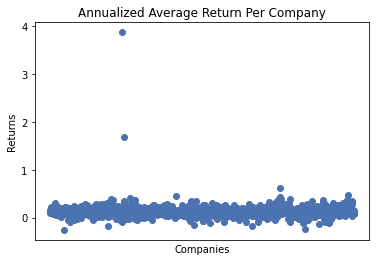

The mean of the annualized average return per company is:  0.13457417919000958 .


<Figure size 432x288 with 0 Axes>

In [ ]:
### Graph creation

plt.scatter(my_annualized_average_return.index,my_annualized_average_return)
plt.title("Annualized Average Return Per Company")
plt.xlabel("Companies")
plt.ylabel("Returns")
plt.tick_params(
   axis='x',          # Changes apply to the x-axis
   which='both',      # Both major and minor ticks are affected
   bottom=False,      # Ticks along the bottom edge are off
   top=False,         # Ticks along the top edge are off
   labelbottom=False) # Labels along the bottom edge are off
plt.show()
fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_annualized_average_return_plot.png'
plt.savefig(fn)
print("The mean of the annualized average return per company is: ", my_annualized_average_return.mean(),".")

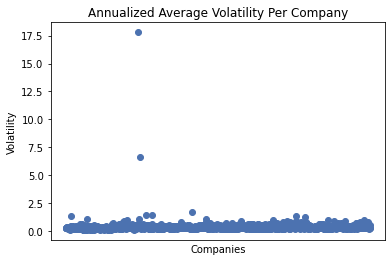

The mean of the annualized average return per company is:  0.40479671962960945 .


<Figure size 432x288 with 0 Axes>

In [ ]:
### Graph creation my_annualized_volatility.values

plt.scatter(my_annualized_volatility.index, my_annualized_volatility)
plt.title("Annualized Average Volatility Per Company")
plt.xlabel("Companies")
plt.ylabel("Volatility")
plt.tick_params(
   axis='x',          # Changes apply to the x-axis
   which='both',      # Both major and minor ticks are affected
   bottom=False,      # Ticks along the bottom edge are off
   top=False,         # Ticks along the top edge are off
   labelbottom=False) # Labels along the bottom edge are off
plt.show()
fn = '/content/drive/MyDrive/Sustainable Finance (EU-Scope1-3)/my_annualized_average_return_plot.png'
plt.savefig(fn)
print("The mean of the annualized average return per company is: ", my_annualized_volatility.mean(),".")

In [ ]:
# Here it's most interesting to take all the european firms (even though there 
#   are some with NaN values, because with 2739 firms, we have more differences 
#   and we can observe some negative correlations --> better opportunity 
#   for diversification!)
ind_asset_return_corr = return_Q1.corr(method='pearson')

In [ ]:
ind_asset_return_corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# Correlation heatmap of all the firms
sns.heatmap(ind_asset_return_corr)

In [ ]:
### Correlation matrix of a sample
r2 = return_Q1b.sample(n=10,axis=1).reset_index().drop("index", axis=1)
# Return_Q1b.iloc[:,300:310] 
cov_matrix = r2.cov()
# Print(cov_matrix)

plotting.plot_covariance(cov_matrix, plot_correlation=True);

## **Exercice 2**

In [ ]:
### Calculate the equally weighted portfolio

return_Q2a = my_returns_T.copy()

# Initialize the list
eq_portf_returns = ['eq. w. portf','']

# For each month
for i in range(len(return_Q2a.index)):
  sum = 0
  # Create a df of only the values of interest, clean it and calculate the 
  # weight (equal for) each return
  monthly_return_Q2a = return_Q2a.iloc[i,:]
  monthly_return_Q2a =  monthly_return_Q2a.dropna()
  weight             = 1/len(monthly_return_Q2a)

  for n in range(len(monthly_return_Q2a)):
    sum += (monthly_return_Q2a.iloc[n]*weight)
  
  eq_portf_returns.append(sum)

In [ ]:
### Calculate the performance of the portfolio

# Create a dataframe
pf_EW = pd.DataFrame(eq_portf_returns[2:], columns = ['eq_portf_returns'])
  
# Annualized average return = (AAR)
AAR_EW_Q2 = pf_EW.mean()*12

# Annualized volatility
AV_EW_Q2 = pf_EW.std()*math.sqrt(12)
  
# Minimum return of portfolio (of the values of the loop above)
Min_ret_EW_Q2 = pf_EW.min()

# Maximum return
Max_ret_EW_Q2 = pf_EW.max()
 
# Sharpe ratio
SR_EW = (AAR_EW_Q2 - my_rf["rf"].mean()*12) / AV_EW_Q2

# Plot the timeseries
pf_EW['date'] = pd.date_range(start='31/1/2000', periods = len(pf_EW), freq = 'M')
pf_EW.plot(x = "date", y = "eq_portf_returns")

In [ ]:
### Make a table with Summary Statistics

# Create data
data = [["Annualized average return", AAR_EW_Q2], 
        ["Annualized volatility", AV_EW_Q2], 
        ["Minimum return", Min_ret_EW_Q2], 
        ["Maximum return", Max_ret_EW_Q2],
        ["Sharpe ratio", SR_EW]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Equally-weighted portfolio: Summary statistics",'\033[1m')
print(tabulate(data, headers = col_names, tablefmt = "fancy_grid"))

In [ ]:
### Calculate the value-weighted portfolio with monthly rebalancing

return_Q2b = my_returns_T.copy()
size_Q2b   = my_size_T_VW.copy()

# Initialize the list -> The goal is to append it to the returns.xlsx (or not :) )
mr_portf_returns = ['val. w. portf','']

# For each month
for i in range(len(return_Q2b.index)):
  sum = 0
  # Create a df of only the values of interest, clean it and calculate the 
  # total size of all the assets
  monthly_returns_Q2b = return_Q2b.iloc[i,:].dropna()
  monthly_size_Q2b    = size_Q2b.iloc[i,:]
  monthly_data_Q2b    = pd.concat([monthly_returns_Q2b, monthly_size_Q2b], axis=1).dropna() # We drop here because there are more NaNs in the size data set, which don't correspond to the NaNs in return(companies not traded), so we drop after the concat for calculation purposes.
  tot_size_Q2b        = monthly_data_Q2b.iloc[:,1].sum()

  for n in range(len(monthly_data_Q2b)):
    # Adapt the weight for each month: weight = size_asset_i/tot_size_of_assets
    weight = monthly_data_Q2b.iloc[n,1] / tot_size_Q2b
    sum += (monthly_data_Q2b.iloc[n,0] * weight)
  
  mr_portf_returns.append(sum)

In [ ]:
### Calculate the performance of the portfolio

# Create a dataframe
pf_VW = pd.DataFrame(mr_portf_returns[2:], columns = ['mr_portf_returns'])
  
# Annualized average return = (AAR)
AAR_VW_Q2 = pf_VW.mean()*12

# Annualized volatility
AV_VW_Q2 = pf_VW.std()*math.sqrt(12)
  
# Minimum return of portfolio (of the values of the loop above)
Min_ret_VW_Q2 = pf_VW.min()

# Maximum return
Max_ret_VW_Q2 = pf_VW.max()

# Sharpe ratio
SR_VW = (AAR_VW_Q2 - my_rf["rf"].mean()*12) / AV_VW_Q2

# Plot the timeseries
pf_VW['date'] = pd.date_range(start='31/1/2000', periods = len(pf_VW), freq = 'M')
pf_VW.plot(x = "date", y = "mr_portf_returns")

In [ ]:
### Make a table with Summary Statistics

# Create data
data = [["Annualized average return", AAR_VW_Q2], 
        ["Annualized volatility", AV_VW_Q2], 
        ["Minimum return", Min_ret_VW_Q2], 
        ["Maximum return", Max_ret_VW_Q2],
        ["Sharpe ratio", SR_VW]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Value-weighted portfolio: Summary statistics",'\033[1m')
print(tabulate(data, headers=col_names, tablefmt ="fancy_grid"))

## **Exercice 3**

In [ ]:
### Investing all in the asset with the highest annualized average return
##      We are finding and excluding outliers (2 of them) first

# Find the asset with the highest annualized average return computed in point 1
AAR_max = my_annualized_average_return.idxmax() # gets the ISIN of company which has 
                                                # the highest annualized return
# Show the annualized average return and annualized volatility of this one-asset portfolio
g = my_annualized_average_return[AAR_max]
h = my_annualized_volatility[AAR_max]
print('The name of the asset with the highest annualized average is', AAR_max,
      '. It is annualized average return is', g, 'and its annualized volatility is', h, '.') 

return_Q1b.copy()[AAR_max].plot() 
print('The maximum monthly return is', return_Q1b.copy()[AAR_max].max(), '.')

This is an outlier -> We decide to remove it



In [ ]:
# Find the asset with the highest annualized average return computed in point 1, droping 1st outlier
AAR_max2 = my_annualized_average_return.drop(AAR_max).idxmax() # gets the ISIN of the company 
                                                               # which has the highest annualized 
                                                               # return

# Show the annualized average return and annualized volatility of this one-asset portfolio
g2 = my_annualized_average_return[AAR_max2]
h2 = my_annualized_volatility[AAR_max2]
print('The name of the asset with the highest annualized average is', AAR_max2,'. It is annualized average return is', g2, 'and its annualized volatility is', h2, '.') 

return_Q1b.copy()[AAR_max2].plot() 
print('The maximum monthly return is', return_Q1b.copy()[AAR_max2].max(), '.')

This is also an outlier -> To be removed

In [ ]:
# Find the asset with the highest annualized average return computed in point 1 dropping 2nd outlier
my_annualized_average_return3 = my_annualized_average_return.drop(AAR_max)
AAR_max3 = my_annualized_average_return3.drop(AAR_max2).idxmax() # gets the ISIN the 
                                                                 # company which has the highest 
                                                                 # annualized return

# Show the annualized average return and annualized volatility of this one-asset portfolio
g3 = my_annualized_average_return[AAR_max3]
h3 = my_annualized_volatility[AAR_max3]

return_Q1b.copy()[AAR_max3].plot() 


# Summary Statistics
data = [["Company", AAR_max3], 
        ["Highest annualized average return", g3], 
        ["Annualized volatility", h3], 
        ["Maximum monthly return", return_Q1b.copy()[AAR_max3].max()]]

# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Statistics of the firm with the highest annualized average return",'\033[1m')
print(tabulate(data, headers=col_names, tablefmt ="fancy_grid"))



In [ ]:

### Investing all in the asset with the highest annualized average return over 2 years

# Annualized of 2 years
my_returns_2_years = return_Q1b.iloc[0:24,:]

# Calculate the annualized average return of the 2 first years
my_ann_avr_ret_2yr = my_returns_2_years.mean()
my_ann_avr_ret_2yr = my_ann_avr_ret_2yr*12

# Find the max
AAR_max3b = my_ann_avr_ret_2yr.idxmax()

# Calculate the annualized_volatility of the first two years
my_ann_volatility_2yr = my_returns_2_years.std()*(math.sqrt(12))

my_returns_2_years[AAR_max3b].plot()

# Summary Statistics
data = [["Company", AAR_max3b], 
        ["Highest annualized average return", my_ann_avr_ret_2yr[AAR_max3b]], 
        ["Annualized volatility", my_ann_volatility_2yr[AAR_max3b]]]

# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Statistics of the firm with the highest annualized average return over 2 years",'\033[1m')
print(tabulate(data, headers=col_names, tablefmt ="fancy_grid"))

In [ ]:
# Remove the two outliers found 
zz           = ["DE000A1MMCC8", "DE000A255G36"]
my_returns_T = my_returns_T.drop(zz, axis=1)
my_prices_T  = my_prices_T.drop(zz, axis=1)
my_size_T    = my_size_T.drop(zz, axis=1)
my_size_T_VW = my_size_T_VW.drop(zz, axis=1)

## **Exercice 4**

In [ ]:
### Keeping only 50 random firms
returns_Q4     = my_returns_T.copy()
prices_Q4      = my_prices_T.copy()
random50       = returns_Q4.sample(n=50,axis=1).reset_index().drop("index", axis=1)
random50.index = returns_Q4.index

In [ ]:
### Optimal portfolio with minimum variance and monthly rebalancing
##      Using a rolling window of 5 years

# Definitions
FIVE_YEARS = 60 # 5yr * 12months = 60 months
RETURN     = 0

rand50_Q4 = my_returns_T.loc[:,random50ISIN]

# Initialize the list
MV_pf_returns_Q4 = []
MV_pf_weights_Q4 = []

# For each month
for m in range(FIVE_YEARS, len(rand50_Q4)):
  monthly_returns = rand50_Q4.iloc[m,:]

  # Drop the firms which are not selling shares
  monthly_returns = monthly_returns.dropna()
  prices_Q4_r     = prices_Q4[monthly_returns.index]

  # Rolling window on 5 years
  prices_Q4_r = prices_Q4_r.iloc[m-FIVE_YEARS:m,:]

  # Portfolio Creation
  S       = CovarianceShrinkage(prices_Q4_r, frequency=12).ledoit_wolf()
  ef      = EfficientFrontier(monthly_returns.values.tolist(), S) 
  weights = ef.min_volatility()

  MV_pf_returns_Q4.append(ef.portfolio_performance()[RETURN])
  MV_pf_weights_Q4.append(weights)

In [ ]:
# Accessing the weights of the MV portfolio per month (making it accessible in a DataFrame and ordering columns)
df_weights_Q4 = pd.DataFrame(MV_pf_weights_Q4)
df_weights_Q4 = df_weights_Q4.loc[:,random50ISIN] #we need the column order to be the same as the imported tables above, filtered on the 50 random (:)

In [ ]:
### Calculation of the portfolio properties

# Create a dataframe
pf_MV = pd.DataFrame(MV_pf_returns_Q4, columns = ['MV_pf_returns'])

# Annualized average return = (AAR)
AAR_MV_Q4 = pf_MV.mean()*12

# Annualized volatility
AV_MV_Q4 = pf_MV.std()*math.sqrt(12)
  
# Minimum return of portfolio (of the values of the loop above)
Min_ret_MV_Q4 = pf_MV.min()

# Maximum return
Max_ret_MV_Q4 = pf_MV.max()

# Sharpe ratio
SR_MV = (AAR_MV_Q4 - my_rf["rf"].mean()*12) / AV_MV_Q4

In [ ]:
# Calculating the carbon intensity (WACI) of the minimum variance portfolio of each month.

WACI_per_month_Q4 = []

for i in range(len(df_weights_Q4)):
  element = ((df_weights_Q4.iloc[i,:]*my_scopesintensity_monthly_Q3.iloc[i,:])).sum(axis=0)
  WACI_per_month_Q4.append(element)

WACI_Q4 = (sum(WACI_per_month_Q4))/(len(WACI_per_month_Q4))

NameError: ignored

In [ ]:
### Summary Statistics to report the results

# Create data
data = [["Annualized average return", AAR_MV_Q4], 
        ["Annualized volatility", AV_MV_Q4], 
        ["Minimum return", Min_ret_MV_Q4], 
        ["Maximum return", Max_ret_MV_Q4],
        ["Sharpe ratio", SR_MV],
        ["Carbon Intensity", WACI_Q4]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Minimum variance portfolio with monthly rebalancing: Summary statistics",'\033[1m')
print(tabulate(data, headers = col_names, tablefmt = "fancy_grid"))

In [ ]:
### Plots

pf_MV['date'] = pd.date_range(start='31/1/2010', periods=len(pf_MV), freq='M')
pf_MV.plot(x = "date", y="MV_pf_returns")

## **Exercice 5**

In [ ]:
### Optimal portfolios with various target portfolio returns

# Definitions
TARGETED_RETURN_START = 0.02
NB_OF_PORTFOLIOS      = 8
SHARPE_RATIO          = 2

targeted_return = TARGETED_RETURN_START

# Get the correct df for the exercices
rand50_Q5 = random50.copy()
prices_Q5 = my_prices_T.copy()
prices_Q5 = prices_Q5[rand50_Q5.columns]

# Average returns will be used to create the portfolio
avr_returns = rand50_Q5.mean(axis=0)

# To save the results
tr_portf_sharpe = np.zeros((NB_OF_PORTFOLIOS,2)) # Create array with zeros to change later on

# Create a plot of the portfolio
S  = CovarianceShrinkage(prices_Q5, frequency = 12).ledoit_wolf()
ef = EfficientFrontier(avr_returns.values, S)
plotting.plot_efficient_frontier(ef)

# Calculate the steps used to create NB_OF_PORTFOLIOS. 
#     Aiming for a return of 16% was not feasible so instead we create the 
#     same number of portfolio but in a range which corresponds to our data 

# Calculates the step to still have 8 portfolios but between 0.2 and 
# max existing, round 3 after . (choice)
return_step = round((ef._max_return_value - TARGETED_RETURN_START)/NB_OF_PORTFOLIOS,3)


for r in range(NB_OF_PORTFOLIOS):
  weights              = ef.efficient_return(target_return = targeted_return)
  cleaned_weights      = ef.clean_weights()
  tr_portf_sharpe[r,0] = targeted_return
  tr_portf_sharpe[r,1] = ef.portfolio_performance()[SHARPE_RATIO]
  targeted_return      = targeted_return + return_step

## Creation of the table
# Define header names
col_names = ["Targeted Return", "Sharpe Ratio"]
  
# Display table
print("Sharpe ratio per targeted return for the 50 randomly selected firms",'\033[1m')
print(tabulate(tr_portf_sharpe, headers=col_names, tablefmt ="fancy_grid"))

## **Exercice 6**

In [ ]:
### Compare the performance of our portfolios with the EU benchmark

#Definition
TO_2005 = 62     # 5yr * 12months + 2 titres
FROM_2005 = 36   #3yr * 12months

EU_returns_Q8 = my_EU_market_returns    # /!\ EU market returns start only from the 2002-01-31
EW_pf_returns = eq_portf_returns.copy() #equally weighted portfolio starting from 2000
VW_pf_returns = mr_portf_returns.copy() #equally weighted (monthly rebalancing portfolio starting from 2000
min_var_ret   = MV_pf_returns.copy()    # Minimun variance pf -> Sorry le nom de var était déja pris...


dates = EU_returns_Q8.Date
dates = dates[FROM_2005:]

returns_EU = EU_returns_Q8.returns + my_rf.iloc[:,1]
returns_EU = returns_EU[FROM_2005:]

del EW_pf_returns[:TO_2005] #drop months from jan 2000 to dec 2001
del VW_pf_returns[:TO_2005] #drop months from jan 2000 to dec 2001


plt.plot(dates, returns_EU,     label='EU market return')
plt.plot(dates, EW_pf_returns,  label='Equally weighted pf')
plt.plot(dates, VW_pf_returns,  label='Value weighted pf')
plt.plot(dates, min_var_ret,    label='Min variance pf')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

In [ ]:
plt.plot(dates, returns_EU,     label='EU market return')
plt.plot(dates, EW_pf_returns,  label='Equally weighted pf')
plt.xlabel("Date")
plt.ylabel("Monthly Returns")
plt.legend()
plt.title('Performance comparison: EW pf and EU market pf')
plt.show()

plt.plot(dates, returns_EU, label='EU market return')
plt.plot(dates, VW_pf_returns,         label='Value weighted pf')
plt.xlabel("Date")
plt.ylabel("Monthly Returns")
plt.legend()
plt.title('Performance comparison: VW pf and EU market pf')
plt.show()

plt.plot(dates, returns_EU, label='EU market return')
plt.plot(dates, min_var_ret,    label='Min variance pf')
plt.xlabel("Date")
plt.ylabel("Monthly Returns")
plt.legend()
plt.title('Performance comparison: MV pf and EU market pf')
plt.show()


In [ ]:
# Creating table for report
EWpd = pd.DataFrame(EW_pf_returns)
EUpd = pd.DataFrame(EU_returns_Q8.returns) 
VWpd = pd.DataFrame(VW_pf_returns)
MVpd = pd.DataFrame(min_var_ret)

#create data
data = [["Annualized average return", (EWpd.mean())*12, VWpd.mean()*12, MVpd.mean()*12, EUpd.mean()*12], 
        ["Annualized volatility", EWpd.std()*math.sqrt(12), VWpd.std()*math.sqrt(12), MVpd.std()*math.sqrt(12), EUpd.std()*math.sqrt(12)], 
        ["Minimum return", EWpd.min(), VWpd.min(), MVpd.min(), EUpd.min()], 
        ["Maximum return", EWpd.max(), VWpd.max(),MVpd.max(), EUpd.max()]]
  
#define header names
col_names = ["Summary Statistic", "Equally-Weighted", "Value-Weighted", "Minimum Variance", "EU Market"]
  
#display table
print("Performance Comparison Table",'\033[1m')
print(tabulate(data, headers=col_names, tablefmt ="fancy_grid"))

## **Exercice 7**

In [ ]:
### Correlation between returns, volatility, size.


size_Q7 = my_size_T.mean() # The average size
return_Q7 = my_annualized_average_return.copy()
volatility_Q7 = my_annualized_volatility.copy()
# Compute and comment on the simple correlation between returns & volatility.
print(return_Q7.corr(volatility_Q7))

# Compute and comment on the simple correlation between returns & size.
print(return_Q7.corr(size_Q7))

# Compute and comment on the simple correlation between volatility & size.
volatility_Q7.corr(size_Q7)

## **Exercice 8**

In [ ]:
###  Minimum variance portfolio with monthly rebalancing excluding smallest firms

prices_Q8  = my_prices_T.copy()
size_Q8 = my_size_T.copy()
rand50_Q8 = random50.copy()

size_Q8 = size_Q8[rand50_Q8.columns]

# Definitions 
START_KEEPING = round(len(rand50_Q8.columns)/3)
FIVE_YEARS    = 60

# Start new list
MV_pf_returns_Q8 = []


for r in range(FIVE_YEARS, len(rand50_Q8)):
  # Sort size where we only keep the two top tercile (the smallest firms are exclude)
  size_line_tosort = size_Q8.iloc[r,:]
  size_line_sorted = size_line_tosort.sort_values(axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)
  size_droped = size_line_sorted[START_KEEPING:]

  # Take the prices & returns of the firms we are interested in
  prices_Q8_r = prices_Q8[size_droped.index]
  rand50_Q8_r = rand50_Q8[size_droped.index]

  # Only the returns of the month we are interested in and clean it
  monthly_returns = rand50_Q8_r.iloc[r,:]
  monthly_returns = monthly_returns.dropna()

  # Only the prices of the month we are interested in
  prices_Q8_r = prices_Q8_r[monthly_returns.index]

  # Rolling window on 5 years
  prices_Q8_r = prices_Q8_r.iloc[r-FIVE_YEARS:r,:]

  # Portfolio Creation
  S = CovarianceShrinkage(prices_Q8_r, frequency=12).ledoit_wolf()
  ef = EfficientFrontier(monthly_returns.values.tolist(), S) 
  weights = ef.min_volatility()

  MV_pf_returns_Q8.append(ef.portfolio_performance()[0])


In [ ]:
### Calculate the portfolio performance

# Create a dataframe
pf_MV_Q8 = pd.DataFrame(MV_pf_returns_Q8, columns = ['MV_pf_returns_Q8'])

# Annualized average return = (AAR)
AAR_MV_Q8 = pf_MV_Q8.mean()*12

# Annualized volatility
AV_MV_Q8 = pf_MV_Q8.std()*math.sqrt(12)
  
# Minimum return of portfolio (of the values of the loop above)
Min_ret_MV_Q8 = pf_MV_Q8.min()

# Maximum return
Max_ret_MV_Q8 = pf_MV_Q8.max()

# Sharpe ratio
SR_MV_Q8 = (AAR_MV_Q8 - my_rf["rf"].mean()*12) / AV_MV_Q8

In [ ]:
### Summary Statistics

# Create data
data = [["Annualized average return", AAR_MV_Q8], 
        ["Annualized volatility", AV_MV_Q8], 
        ["Minimum return", Min_ret_MV_Q8], 
        ["Maximum return", Max_ret_MV_Q8],
        ["Sharpe ratio", SR_MV_Q8]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("Minimum variance portfolio with monthly rebalancing: Summary statistics",'\033[1m')
print(tabulate(data, headers=col_names, tablefmt ="fancy_grid"))

pf_MV_Q8['date'] = pd.date_range(start='31/1/2000', periods=len(pf_MV_Q8), freq='M')
pf_MV_Q8.plot(x = "date", y="MV_pf_returns_Q8")

## **Exercice 9**

In [ ]:
### Funciton to calculate the equally weighted portfolio

# Inputs: returns
# Outputs: average return of the pf

def fct_EW_creation(returns):
  sum = 0
  # Create a df of only the values of interest, clean it and calculate the 
  # weight (equal for) each return
  if len(returns)==0:
    weight = "nan"
  else:
    weight = 1/len(returns)

  for n in range(len(returns)):
    sum += (returns[n]*weight)
    
  return sum

In [ ]:
### Funciton to calculate the value weighted portfolio

# Inputs: returns, size
# Outputs: average return of the pf

def fct_VW_creation(returns,size):
  sum = 0
  # Create a df of only the values of interest, clean it and calculate the 
  # weight (equal for) each return
  total_size = size.sum()

  for n in range(len(returns)):
    if np.isnan(size[n]):
      weight = 0
    else:
      weight = size[n]/total_size

    sum += (returns[n]*weight)
    
    
    
  return sum

In [ ]:
### Equally-weighted and value-weighted portfolios for each size quantiles and long-short for Q1&Q5

prices_Q9  = my_prices_T.copy()
returns_Q9 = my_returns_T.copy()
size_Q9    = my_size_T.copy()
size_Q9_VW = my_size_T_VW.copy()

QUANTILE_1 = 0 # Small firms
QUANTILE_2 = 1
QUANTILE_3 = 2
QUANTILE_4 = 3
QUANTILE_5 = 4 # Big firms
NB_QUANTILES = 5

# Create a list for the return of the EW
avr_ret_EW    = []
avr_ret_VW    = []
avr_ret_EW_sl = []
avr_ret_VW_sl = []


for m in range(len(returns_Q9)):
  avr_ret_EWq = []
  avr_ret_VWq = []
  avr_ret_EW_sl_q = 0   # For the portfolio short&long
  avr_ret_VW_sl_q = 0   # For the portfolio short&long
  
  # Order size
  size_sorted = size_Q9.iloc[m,:].sort_values(axis=0, ascending=True, ignore_index=False).dropna()

  # split size in 5 quintiles -> Liste of names
  q_list = np.array_split(size_sorted,5) # Split the pd.Series into 5 equal parts

  for q in range(NB_QUANTILES):
    # Only the returns of the month & firms we are interested in and clean it
    return_q = returns_Q9[q_list[q].index]
    return_q = return_q.iloc[m,:].dropna()

    # Only the size of the month & firms we are interested in for the VW pf
    size_q = size_Q9_VW[return_q.index]
    size_q = size_q.iloc[m,:]

    # Only the prices of the month & firms we are interested in
    prices_q = prices_Q9[return_q.index]

    # Create an EW pf 
    avrR_EW = fct_EW_creation(return_q)
    avr_ret_EWq.append(avrR_EW)

    # Create a VW pf
    avrR_VW = fct_VW_creation(return_q, size_q)
    avr_ret_VWq.append(avrR_VW)

    # For the EW & VW long & short pf
    if q == QUANTILE_1:
      avrR_EW_q1 = avrR_EW
      avrR_VW_q1 = avrR_VW
    elif q == QUANTILE_5:
      avr_ret_EW_sl_q = ((0.5*avrR_EW_q1)-(0.5*avrR_EW))
      avr_ret_VW_sl_q = ((0.5*avrR_VW_q1)-(0.5*avrR_VW))

  # Add to the final list
  avr_ret_EW.append(avr_ret_EWq)
  avr_ret_VW.append(avr_ret_VWq)
  avr_ret_EW_sl.append(avr_ret_EW_sl_q)
  avr_ret_VW_sl.append(avr_ret_VW_sl_q)


print(avr_ret_EW)
print(avr_ret_VW)
print(avr_ret_EW_sl)
print(avr_ret_VW_sl)


[[0.07463614671478341, 0.03930377909342143, 0.038604649737695174, -0.0006250009427026192, -0.055620484104491406], [0.05032790811410545, 0.07444315487504237, 0.0650841484076494, 0.10904893656018062, 0.09505711330755275], [-0.006597321765410539, -0.00541503452890336, 0.00415722169025113, 0.00977039685697392, 0.022603300988761732], [-0.05641730405873267, -0.055000946844559175, -0.049538081826199995, -0.0488312258048986, -0.034058526718832846], [-0.014380053244139593, -0.009363251375600326, 0.009567248698545708, 0.00412189845433461, 0.0034823732516124067], [0.02976237319140209, 0.05518015530183305, 0.04330843633543204, 0.05800029786565455, 0.046583234881789816], [-0.011217470927330614, -0.030445319299355903, -0.010091346450783982, 0.00563491089531391, 0.0032867423055128646], [0.0030744099275025073, 0.02550476423525112, 0.0330108335731502, 0.03056594861011788, 0.003411593478153482], [-0.025486641221274024, -0.026207788656747378, -0.019632482567745024, -0.02985314427226678, -0.03296302377079

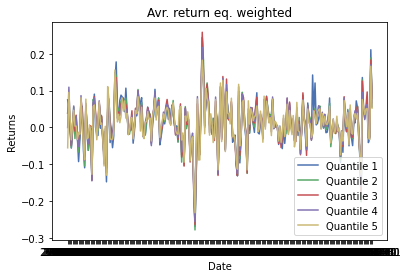

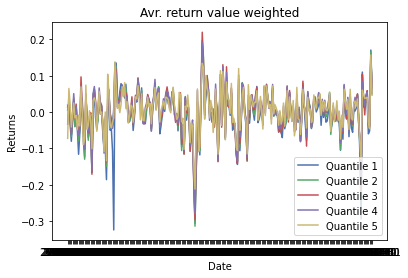

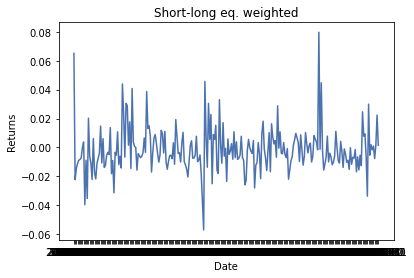

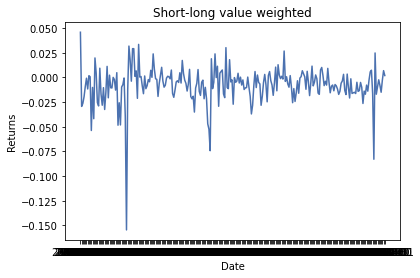

In [ ]:
### Graphs

# Eq. weighted
df = pd.DataFrame(avr_ret_EW)

plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_2], label='Quantile 2')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_3], label='Quantile 3')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_4], label='Quantile 4')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avr. return eq. weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Value weighted
df = pd.DataFrame(avr_ret_VW)

plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_2], label='Quantile 2')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_3], label='Quantile 3')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_4], label='Quantile 4')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avr. return value weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Short-long eq. w.
plt.plot(returns_Q9.index, avr_ret_EW_sl)
plt.title('Short-long eq. weighted')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Short-long value w.
plt.plot(returns_Q9.index, avr_ret_VW_sl)
plt.title('Short-long value weighted')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()



In [ ]:
import statistics
print(statistics.mean(avr_ret_EW_sl),"&",statistics.mean(avr_ret_VW_sl))

In [ ]:
# report
df = pd.DataFrame(avr_ret_EW)

l1 = [df.iloc[:,QUANTILE_1].mean()]*len(returns_Q9)
l5 = [df.iloc[:,QUANTILE_5].mean()]*len(returns_Q9)

plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.plot(returns_Q9.index, l1, label='Q1: Avg. return across months')
plt.plot(returns_Q9.index, l5, label='Q5: Avg. return across months')
plt.title('Avg. return eq. weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

print("The average returns of Q1 over all years: ", df.iloc[:,QUANTILE_1].mean(), ". The average returns of Q5 over all years: ", df.iloc[:,QUANTILE_5].mean())
print(
    df.iloc[:,QUANTILE_1].mean(),
    df.iloc[:,QUANTILE_2].mean(),
    df.iloc[:,QUANTILE_3].mean(),
    df.iloc[:,QUANTILE_4].mean(),
    df.iloc[:,QUANTILE_5].mean()
)

df = pd.DataFrame(avr_ret_VW)

l1 = [df.iloc[:,QUANTILE_1].mean()]*len(returns_Q9)
l5 = [df.iloc[:,QUANTILE_5].mean()]*len(returns_Q9)

plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index, df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.plot(returns_Q9.index, l1, label='Q1: Avg. return across months')
plt.plot(returns_Q9.index, l5, label='Q5: Avg. return across months')
plt.title('Avg. return value weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

print("The average returns of Q1 over all years: ", df.iloc[:,QUANTILE_1].mean(), ". The average returns of Q5 over all years: ", df.iloc[:,QUANTILE_5].mean())
print(
    df.iloc[:,QUANTILE_1].mean(),
    df.iloc[:,QUANTILE_2].mean(),
    df.iloc[:,QUANTILE_3].mean(),
    df.iloc[:,QUANTILE_4].mean(),
    df.iloc[:,QUANTILE_5].mean()
)

In [ ]:
### Equally-weighted and value-weighted portfolios for each past stock returns 
### quantiles and long-short for Q1&Q5

prices_Q9  = my_prices_T.copy()
returns_Q9 = my_returns_T.copy()
size_Q9    = my_size_T.copy()
size_Q9_VW = my_size_T_VW.copy()

# Definitions
STARTING_MONTH = 12
SUM_ON_MONTHS  = 12
QUANTILE_1     = 0 #Small firms
QUANTILE_2     = 1
QUANTILE_3     = 2
QUANTILE_4     = 3
QUANTILE_5     = 4 #Big firms
NB_QUANTILES   = 5

# Create a list for the return of the EW
avr_ret_EW    = []
avr_ret_VW    = []
avr_ret_EW_sl = []
avr_ret_VW_sl = []


for m in range(STARTING_MONTH, len(returns_Q9)):
  avr_ret_EWq = []
  avr_ret_VWq = []
  avr_ret_EW_sl_q = 0 # For the portfolio short&long
  avr_ret_VW_sl_q = 0 # For the portfolio short&long
  
  # Order size
  cum_ret = returns_Q9.iloc[m - SUM_ON_MONTHS:m,:].sum(axis=0)
  cum_ret_sorted = cum_ret.sort_values(axis=0, ascending=True, ignore_index=False).dropna()

  # split size in 5 quintiles -> Liste de nom
  q_list = np.array_split(cum_ret_sorted,5) # Split the pd.Series into 5 equal parts

  for q in range(NB_QUANTILES):
    # Only the returns of the month & firms we are interested in and clean it
    return_q = returns_Q9[q_list[q].index]
    return_q = return_q.iloc[m,:].dropna()

    size_q = size_Q9_VW[return_q.index]
    size_q = size_q.iloc[m,:]

    # Create an EW pf 
    avrR_EW = fct_EW_creation(return_q)
    avr_ret_EWq.append(avrR_EW)

    # Create a  VW pf
    avrR_VW = fct_VW_creation(return_q, size_q)
    avr_ret_VWq.append(avrR_VW)

    # For the EW & VW long & short pf
    if q == QUANTILE_1:
      avrR_EW_q1 = avrR_EW
      avrR_VW_q1 = avrR_VW
    elif q == QUANTILE_5:
      avr_ret_EW_sl_q = ((0.5*avrR_EW_q1)-(0.5*avrR_EW))
      avr_ret_VW_sl_q = ((0.5*avrR_VW_q1)-(0.5*avrR_VW))

  # Add to the final list
  avr_ret_EW.append(avr_ret_EWq)
  avr_ret_VW.append(avr_ret_VWq)
  avr_ret_EW_sl.append(avr_ret_EW_sl_q)
  avr_ret_VW_sl.append(avr_ret_VW_sl_q)

print(avr_ret_EW)
print(avr_ret_VW)
print(avr_ret_EW_sl)
print(avr_ret_VW_sl)

In [ ]:
### Graphs

# Eq. weighted
df = pd.DataFrame(avr_ret_EW)

plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_2], label='Quantile 2')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_3], label='Quantile 3')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_4], label='Quantile 4')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avr. return eq. weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

print("The average returns of Q1 over all years: ", df.iloc[:,QUANTILE_1].mean(), ". The average returns of Q5 over all years: ", df.iloc[:,QUANTILE_5].mean())
print(
    df.iloc[:,QUANTILE_1].mean(),
    df.iloc[:,QUANTILE_2].mean(),
    df.iloc[:,QUANTILE_3].mean(),
    df.iloc[:,QUANTILE_4].mean(),
    df.iloc[:,QUANTILE_5].mean()
)

# Value weighted
df = pd.DataFrame(avr_ret_VW)

plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_2], label='Quantile 2')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_3], label='Quantile 3')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_4], label='Quantile 4')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.title('Avr. return value weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Short-long eq. w.
plt.plot(returns_Q9.index[STARTING_MONTH:], avr_ret_EW_sl)
plt.title('Short-long eq. weighted')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

# Short-long value w.
plt.plot(returns_Q9.index[STARTING_MONTH:], avr_ret_VW_sl)
plt.title('Short-long value weighted')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

print("The average returns of Q1 over all years: ", df.iloc[:,QUANTILE_1].mean(), ". The average returns of Q5 over all years: ", df.iloc[:,QUANTILE_5].mean())
print(
    df.iloc[:,QUANTILE_1].mean(),
    df.iloc[:,QUANTILE_2].mean(),
    df.iloc[:,QUANTILE_3].mean(),
    df.iloc[:,QUANTILE_4].mean(),
    df.iloc[:,QUANTILE_5].mean()
)

In [ ]:
#Report

df = pd.DataFrame(avr_ret_EW)

l1 = [df.iloc[:,QUANTILE_1].mean()]*len(returns_Q9[STARTING_MONTH:])
l5 = [df.iloc[:,QUANTILE_5].mean()]*len(returns_Q9[STARTING_MONTH:])

plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.plot(returns_Q9.index[STARTING_MONTH:], l1, label='Q1: Avg. return across months')
plt.plot(returns_Q9.index[STARTING_MONTH:], l5, label='Q5: Avg. return across months')
plt.title('Avg. return eq. weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

df = pd.DataFrame(avr_ret_VW)

l1 = [df.iloc[:,QUANTILE_1].mean()]*len(returns_Q9[STARTING_MONTH:])
l5 = [df.iloc[:,QUANTILE_5].mean()]*len(returns_Q9[STARTING_MONTH:])

plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_1], label='Quantile 1')
plt.plot(returns_Q9.index[STARTING_MONTH:], df.iloc[:,QUANTILE_5], label='Quantile 5')
plt.plot(returns_Q9.index[STARTING_MONTH:], l1, label='Q1: Avg. return across months')
plt.plot(returns_Q9.index[STARTING_MONTH:], l5, label='Q5: Avg. return across months')
plt.title('Avg. return value weighted')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

## **Appendix**

In [ ]:
### Calculate the performance of the EU market overall to have a benchmark for us
  
# Annualized average return = (AAR)
EU_ret = (my_EU_market_returns["returns"] + my_rf["rf"]).mean()*12

# Annualized volatility
EU_vol = (my_EU_market_returns["returns"] + my_rf["rf"]).std()*(math.sqrt(12))

# Sharpe ratio
EU_SR = (EU_ret - my_rf["rf"].mean()*12) / EU_vol

### Make a table with Summary Statistics

# Create data
data = [["Annualized average return", EU_ret], 
        ["Annualized volatility", EU_vol],
        ["Sharpe ratio", EU_SR]]
  
# Define header names
col_names = ["Summary Statistic", "Value"]
  
# Display table
print("EU market portfolio: Summary statistics",'\033[1m')
print(tabulate(data, headers=col_names, tablefmt ="fancy_grid"))

In [ ]:
# For illustration purposes in report
print(my_returns_T.iloc[0:5,[8,10,11,12]])